## Loading of Miller ECoG data of motor imagery

includes some visualizations

In [2]:
# @title Data retrieval
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile('data/' + fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
# @title Data loading
import numpy as np
from scipy import signal

alldat = np.load('data/' + fname, allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat1 = alldat[0][0]
dat2 = alldat[0][1]

# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. Raw data and dataset paper are here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522
https://www.nature.com/articles/s41562-019-0678-3

This particular dataset was originally described in this paper:

- Miller, Kai J., Gerwin Schalk, Eberhard E. Fetz, Marcel Den Nijs, Jeffrey G. Ojemann, and Rajesh PN Rao. "Cortical activity during motor execution, motor imagery, and imagery-based online feedback." Proceedings of the National Academy of Sciences (2010): 200913697. doi: [10.1073/pnas.0913697107](https://doi.org/10.1073/pnas.0913697107)

<br>

`dat1` and `dat2` are data from the two blocks performed in each subject. The first one was the actual movements, the second one was motor imagery. For the movement task, from the original dataset instructions:

*Patients performed simple, repetitive, motor tasks of hand (synchronous flexion and extension of all fingers, i.e., clenching and releasing a fist at a self-paced rate of ~1-2 Hz) or tongue (opening of mouth with protrusion and retraction of the tongue, i.e., sticking the tongue in and out, also at ~1-2 Hz). These movements were performed in an interval-based manner, alternating between movement and rest, and the side of move- ment was always contralateral to the side of cortical grid placement.*

<br>

For the imagery task, from the original dataset instructions:

*Following the overt movement experiment, each subject performed an imagery task, imagining making identical movement rather than executing the movement. The imagery was kinesthetic rather than visual (“imagine yourself performing the actions like you just did”; i.e., “don’t imagine what it looked like, but imagine making the motions”).*

<br>

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size. Please convert back to float32 after loading the data in the notebook, to avoid unexpected behavior.

Both experiments:
* `dat['V']`: continuous voltage data (time by channels)
* `dat['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat['t_on']`: time of stimulus onset in data samples
* `dat['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat['stim_id`]: identity of stimulus (11 = tongue, 12 = hand), real or imaginary stimulus
* `dat['scale_uv']`: scale factor to multiply the data values to get to microvolts (uV).
* `dat['locs`]`: 3D electrode positions on the brain surface

In [5]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat1['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

In [6]:
from scipy import signal

def plot_PSD_concat(V_tongue_concat, V_hand_concat, V_rest_concat, num_chs):
  plt.figure(figsize=(20, 40))
  for idx_ch in range(num_chs):
  
    # Computing thestatic PSD
    window = np.hanning(len(V_tongue_concat[idx_ch,:]))
    PSD_tongue = np.abs(np.fft.fft(V_tongue_concat[idx_ch,:] * window)) ** 2
    PSD_hand = np.abs(np.fft.fft(V_hand_concat[idx_ch,:] * window)) ** 2
    PSD_rest = np.abs(np.fft.fft(V_rest_concat[idx_ch,:] * window)) ** 2
    freq = np.fft.fftfreq(len(V_tongue_concat[idx_ch,:]), 1 / dat1['srate'])

    # take the envelope
    b, a = signal.butter(3, [15], btype='low', fs=1000)
    PSD_tongue_env = signal.filtfilt(b, a, PSD_tongue, 0)
    PSD_hand_env = signal.filtfilt(b, a, PSD_hand, 0)
    PSD_rest_env = signal.filtfilt(b, a, PSD_rest, 0)

    # Make plots
    ax = plt.subplot(np.ceil(num_chs / 2).astype(int), 2, idx_ch+1)
    plt.plot(freq[0:int(len(PSD_tongue_env)/2)], PSD_tongue_env[0:int(len(PSD_tongue_env)/2)]  * freq[0:int(len(PSD_tongue_env)/2)], label = 'tongue')
    plt.plot(freq[0:int(len(PSD_hand_env)/2)], PSD_hand_env[0:int(len(PSD_hand_env)/2)]  * freq[0:int(len(PSD_hand_env)/2)], label = 'hand')
    plt.plot(freq[0:int(len(PSD_rest_env)/2)], PSD_rest_env[0:int(len(PSD_rest_env)/2)]  * freq[0:int(len(PSD_rest_env)/2)], label = 'rest')
    plt.title(f'ch{idx_ch}, {dat1["gyrus"][idx_ch]}, {dat1["Brodmann_Area"][idx_ch]}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')

    #  Set x-axis limits
    plt.xlim(0, 32)
    plt.legend()

  plt.show()


In [11]:
def plot_PSD_no_concat(V_tongue, V_hand, V_rest, num_chs, freqs_range):
    
    plt.figure(figsize=(20, 30))
    for idx_ch in range(num_chs):
  
      # Computing the static PSD
      freq = np.fft.fftfreq(len(V_tongue[0,:,idx_ch]), 1 / dat1['srate'])
      PSD_tongue_all = np.abs(np.fft.fft(V_tongue[:,:,idx_ch], axis=1)) ** 2
      PSD_tongue_log = 10 * np.log10(PSD_tongue_all)
      PSD_tongue_log_mean = np.mean(PSD_tongue_log, axis=0)
      PSD_tongue_log_std = np.std(PSD_tongue_log, axis=0) / np.sqrt(30)

      PSD_hand_all = np.abs(np.fft.fft(V_hand[:,:,idx_ch], axis=1)) ** 2
      PSD_hand_log = 10 * np.log10(PSD_hand_all)
      PSD_hand_log_mean = np.mean(PSD_hand_log, axis=0)
      PSD_hand_log_std = np.std(PSD_hand_log, axis=0) / np.sqrt(30)

      PSD_rest_all = np.abs(np.fft.fft(V_rest[:,:,idx_ch], axis=1)) ** 2
      PSD_rest_log = 10 * np.log10(PSD_rest_all)
      PSD_rest_log_mean = np.mean(PSD_rest_log, axis=0)
      PSD_rest_log_std = np.std(PSD_rest_log, axis=0) / np.sqrt(30)

      # Make plots
      ax = plt.subplot(np.ceil(num_chs / 2).astype(int), 2, idx_ch+1)
      plt.plot(freq[:int(PSD_tongue_log_mean.shape[0]/2)], PSD_tongue_log_mean[:int(PSD_tongue_log_mean.shape[0]/2)], label = 'mean tongue')
      plt.fill_between(freq[:int(PSD_tongue_log_mean.shape[0]/2)], PSD_tongue_log_mean[:int(PSD_tongue_log_mean.shape[0]/2)] - PSD_tongue_log_std[:int(PSD_tongue_log_mean.shape[0]/2)], PSD_tongue_log_mean[:int(PSD_tongue_log_mean.shape[0]/2)] + PSD_tongue_log_std[:int(PSD_tongue_log_mean.shape[0]/2)], alpha=0.3, label='std tongue')
      plt.plot(freq[:int(PSD_hand_log_mean.shape[0]/2)], PSD_hand_log_mean[:int(PSD_hand_log_mean.shape[0]/2)], label = 'mean hand')
      plt.fill_between(freq[:int(PSD_hand_log_mean.shape[0]/2)], PSD_hand_log_mean[:int(PSD_hand_log_mean.shape[0]/2)] - PSD_hand_log_std[:int(PSD_hand_log_mean.shape[0]/2)], PSD_hand_log_mean[:int(PSD_hand_log_mean.shape[0]/2)] + PSD_hand_log_std[:int(PSD_hand_log_mean.shape[0]/2)], alpha=0.3, label='std hand')
      plt.plot(freq[:int(PSD_rest_log_mean.shape[0]/2)], PSD_rest_log_mean[:int(PSD_rest_log_mean.shape[0]/2)], label = 'mean rest')
      plt.fill_between(freq[:int(PSD_rest_log_mean.shape[0]/2)], PSD_rest_log_mean[:int(PSD_rest_log_mean.shape[0]/2)] - PSD_rest_log_std[:int(PSD_rest_log_mean.shape[0]/2)], PSD_rest_log_mean[:int(PSD_rest_log_mean.shape[0]/2)] + PSD_rest_log_std[:int(PSD_rest_log_mean.shape[0]/2)], alpha=0.3, label='std rest')
      plt.title(f'ch{idx_ch}, {dat1["gyrus"][idx_ch]}, {dat1["Brodmann_Area"][idx_ch]}')
      plt.xlabel('Frequency (Hz)')
      plt.ylabel('Power')

      #  Set x-axis limits
      if freqs_range == 'beta':
        plt.xlim(12, 32)
        plt.ylim(55, 85)
      elif freqs_range == 'theta':
         plt.xlim(4, 8)
         plt.ylim(70, 90)
      elif freqs_range == 'hfb':
         plt.xlim(50, 100)
         plt.ylim(40,65)
      plt.legend()

    plt.show()
  

In [12]:
def split_dataset(dat, concat=False):

    # Convert data to float32
    V = dat['V'].astype('float32')

    # Rescaling the voltage channels
    V_ = V * dat['scale_uv']

    trial_len_samp = 2000

    if concat:
        rest_sample = 1000
    else:
        rest_sample = 2000

    nt, nchan = V_.shape
    nstim = len(dat['t_on'])
    trange = np.arange(0, trial_len_samp)
    ts_on = dat['t_on'][:, np.newaxis] + trange
    ts_off = dat['t_off'][:, np.newaxis] + trange[0:rest_sample]

    V_epochs_on = np.reshape(V_[ts_on, :], (nstim, trial_len_samp, nchan))

    V_tongue = (V_epochs_on[dat['stim_id'] == 11])
    V_hand = (V_epochs_on[dat['stim_id'] == 12])
    V_rest = np.reshape(V_[ts_off, :], (nstim, rest_sample, nchan))
    
    return V_tongue, V_hand, V_rest


In [9]:
def concatenate_epochs(V_tongue, V_hand, V_rest):
    # Reshape the signals
    V_tongue_concat = np.zeros((V_tongue.shape[2], V_tongue.shape[0]*V_tongue.shape[1]))
    V_hand_concat = np.zeros((V_hand.shape[2], V_hand.shape[0]*V_hand.shape[1]))
    V_rest_concat = np.zeros((V_rest.shape[2], V_rest.shape[0]*V_rest.shape[1]))
    for ch in range(V_tongue.shape[2]):
        V_tongue_concat[ch] = np.reshape(V_tongue[:,:,ch], (1,-1))
        V_hand_concat[ch] = np.reshape(V_hand[:,:,ch], (1,-1))
        V_rest_concat[ch] = np.reshape(V_rest[:,:,ch], (1,-1))
    
    return V_tongue_concat, V_hand_concat, V_rest_concat

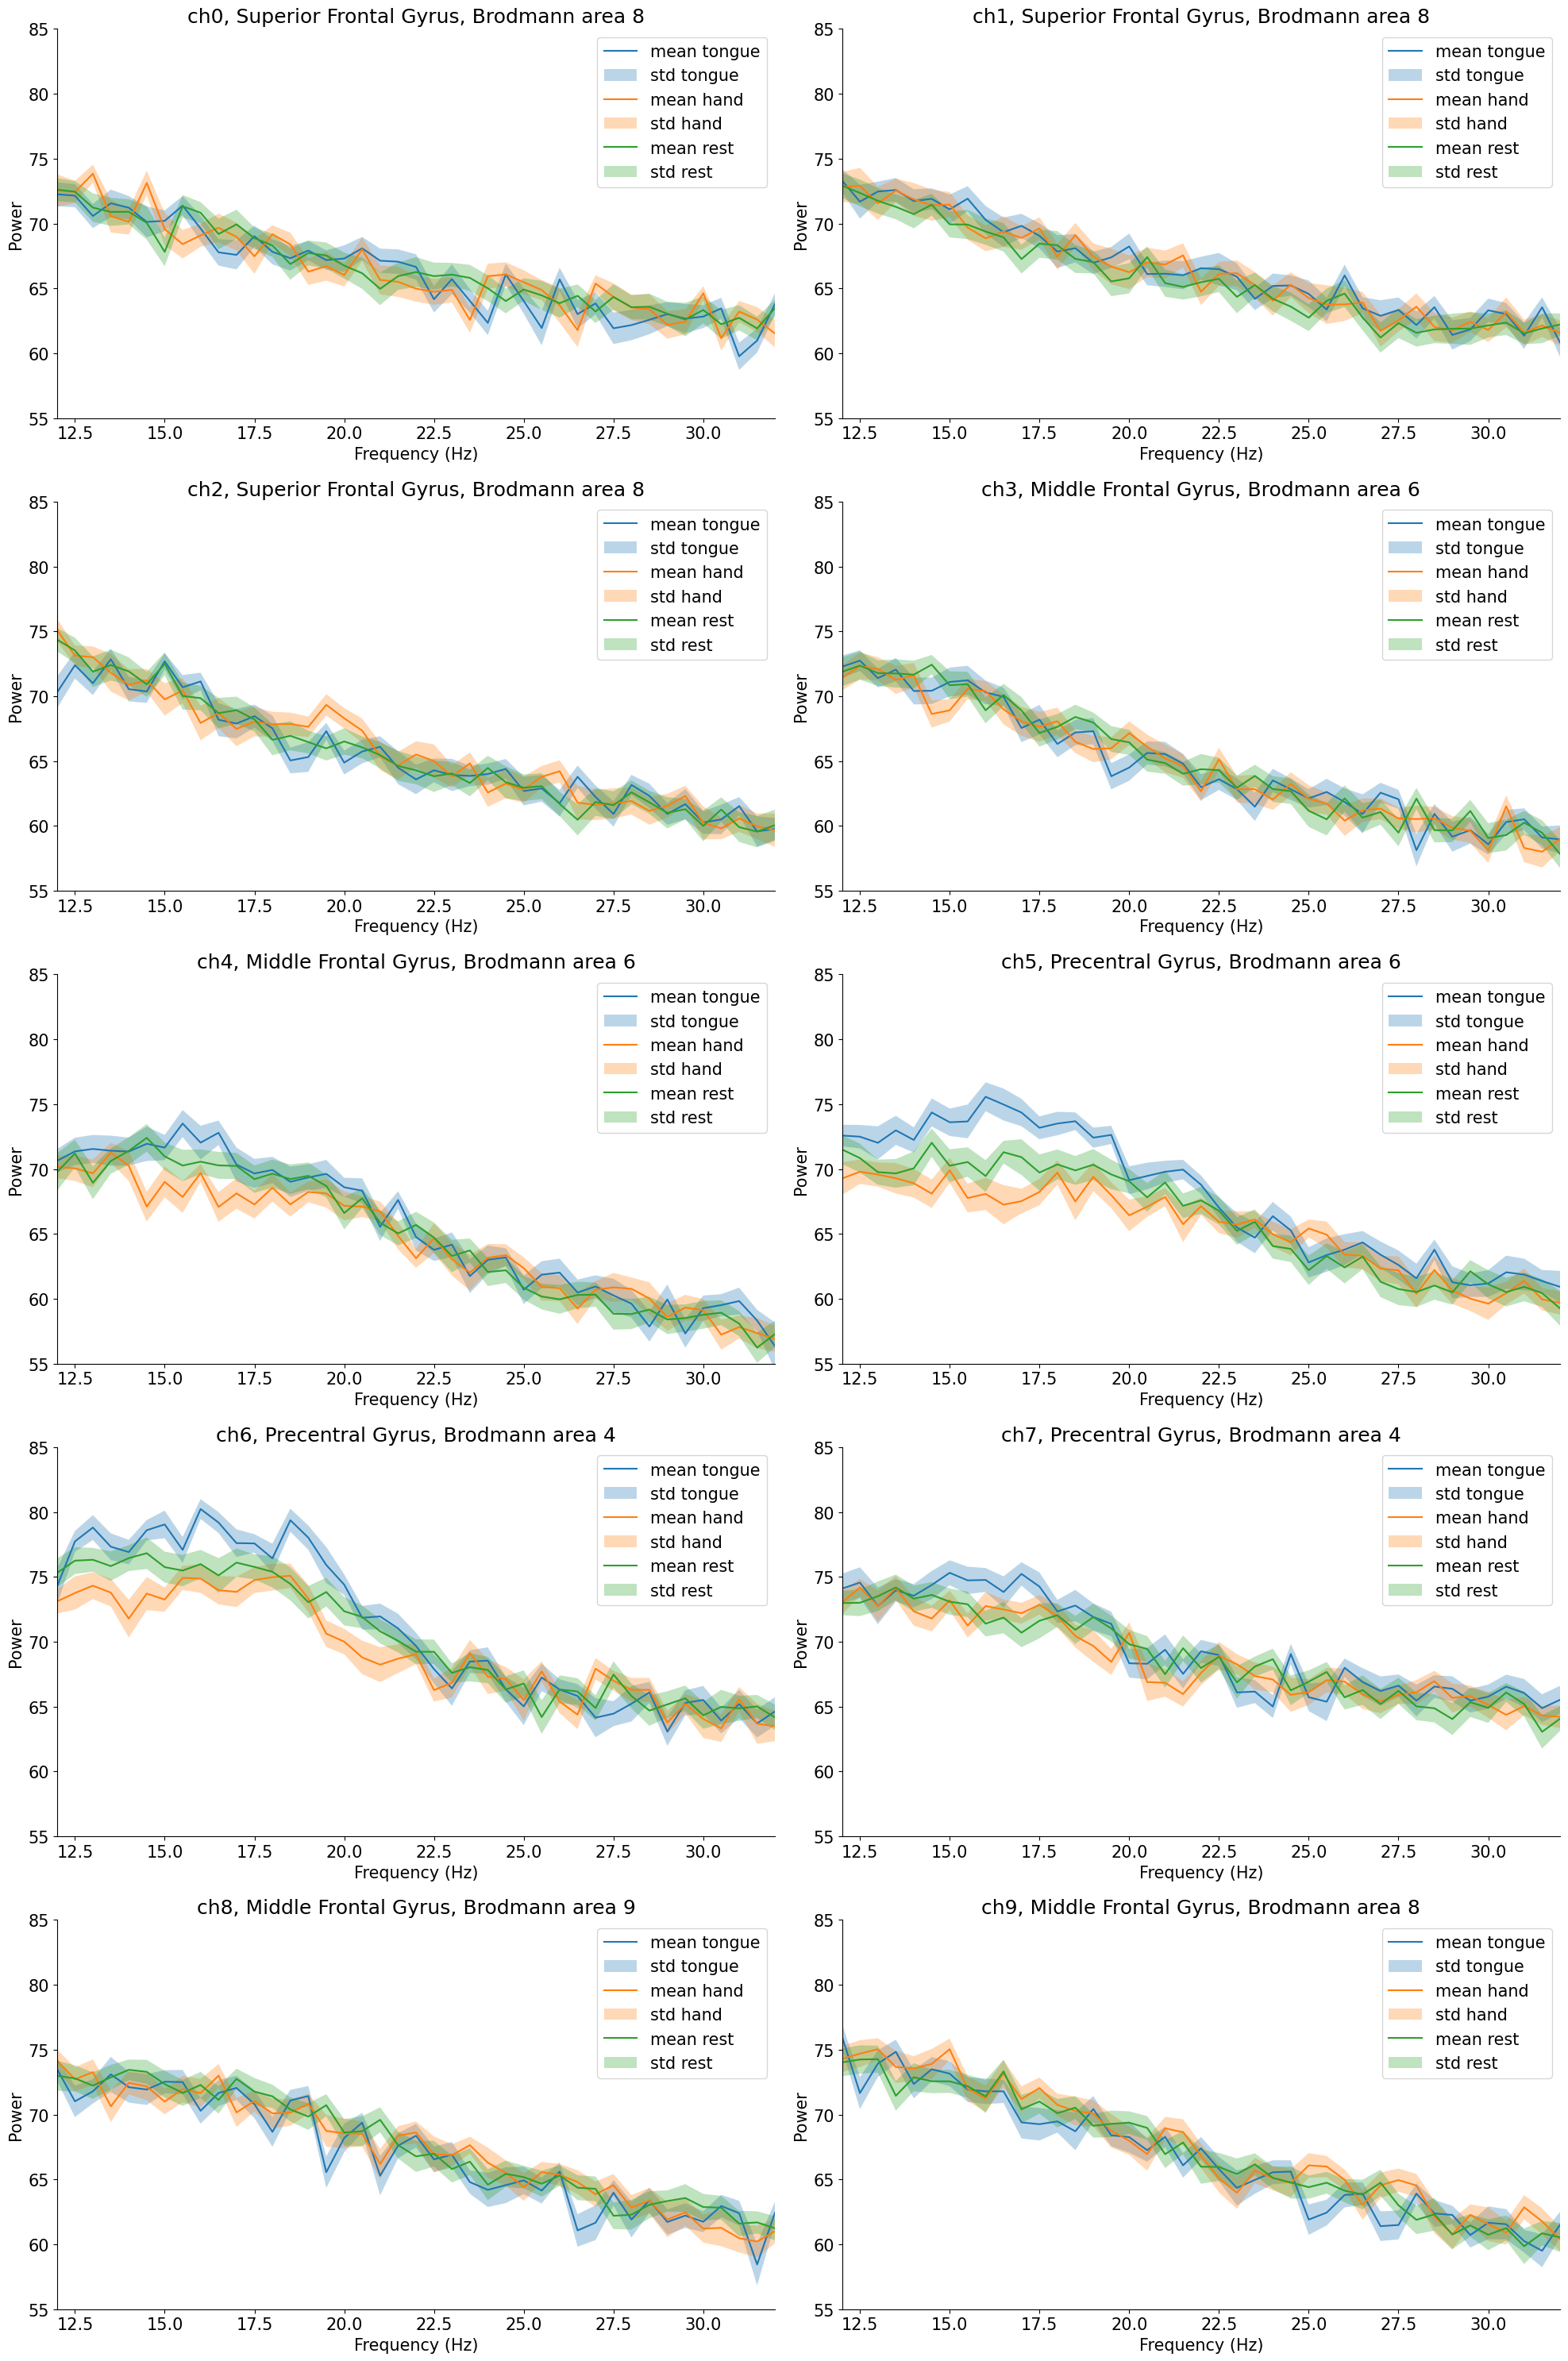

In [13]:
# Real Motor execution
V_tongue, V_hand, V_rest = split_dataset(dat1)

# Concatenate the epochs
V_tongue_concat, V_hand_concat, V_rest_concat = concatenate_epochs(V_tongue, V_hand, V_rest)

# How many trials do you want to visualize?
num_chs = 10

# Plot the PSD avg, std all trials
plot_PSD_no_concat(V_tongue, V_hand, V_rest, num_chs, freqs_range='beta')


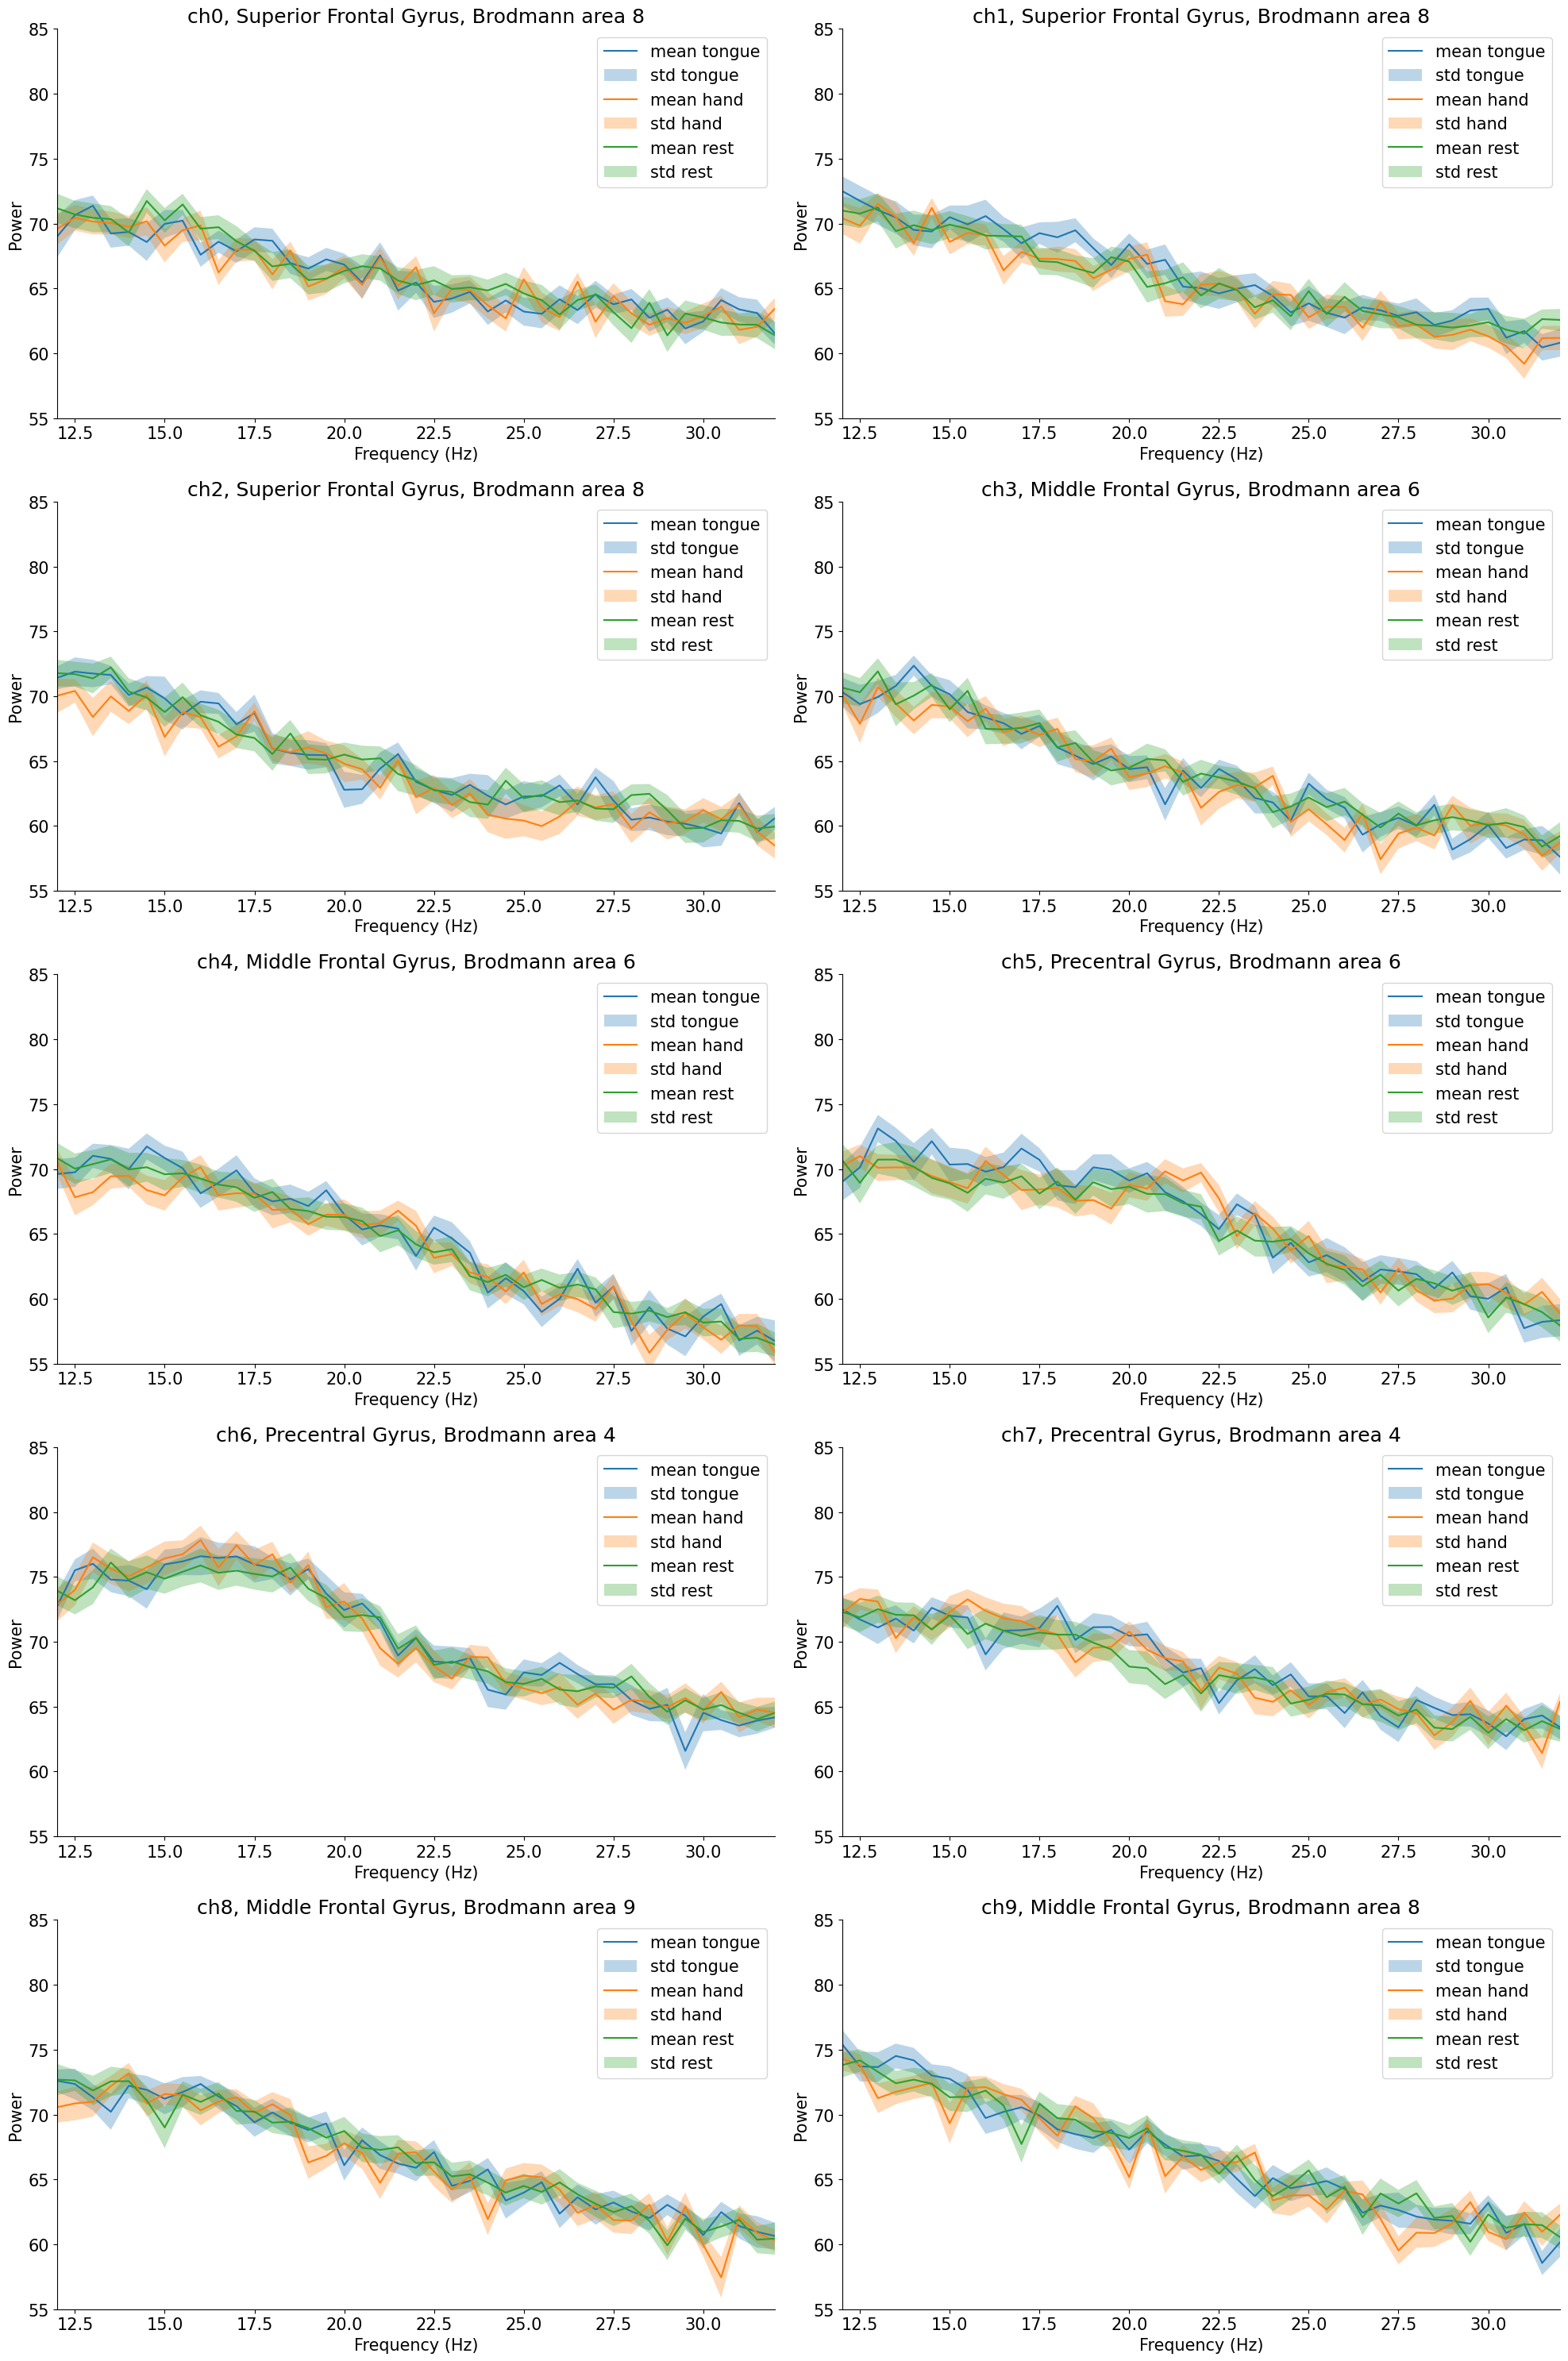

In [14]:
# Motor Imagery
V_tongue, V_hand, V_rest = split_dataset(dat2)

# Concatenate the epochs
V_tongue_concat, V_hand_concat, V_rest_concat = concatenate_epochs(V_tongue, V_hand, V_rest)

# How many trials do you want to visualize?
num_chs = 10

# Plot the PSD avg, std all trials
plot_PSD_no_concat(V_tongue, V_hand, V_rest, num_chs, freqs_range='beta')

In [18]:
def extract_power_features(V, freq, btype):

    trial_len_samp = 3000

    # high-pass filter above 50 Hz
    b, a = signal.butter(3, freq, btype=btype, fs=1000)
    V = signal.filtfilt(b, a, V, 0)

    # compute smooth envelope of this signal = approx power
    V = np.abs(V)**2
    b, a = signal.butter(3, [10], btype='low', fs=1000)
    V = signal.filtfilt(b, a, V, 0)

    # normalize each channel so its mean power is 1
    V = V/V.mean(0)

    nt, nchan = V.shape
    nstim = len(dat1['t_on'])

    trange = np.arange(0, trial_len_samp)
    ts = dat1['t_on'][:, np.newaxis] + trange

    V_epochs = np.reshape(V[ts, :], (nstim, trial_len_samp, nchan))

    V_tongue = (V_epochs[dat1['stim_id'] == 11])
    V_hand = (V_epochs[dat1['stim_id'] == 12])

    return V_tongue, V_hand, trange

In [19]:
# V is the voltage data
V = dat1['V'].astype('float32')

V_high_tongue_me, V_high_hand_me, trange = extract_power_features(V, freq=[70, 100], btype='bandpass')
V_low_tongue_me, V_low_hand_me, trange = extract_power_features(V, freq=[8,32], btype='bandpass')
V_theta_tongue_me, V_theta_hand_me, trange = extract_power_features(V, freq=[4,8], btype='bandpass')

# V is the voltage data
V = dat2['V'].astype('float32')

V_high_tongue_mi, V_high_hand_mi, trange = extract_power_features(V, freq=[70, 100], btype='bandpass')
V_low_tongue_mi, V_low_hand_mi, trange = extract_power_features(V, freq=[8,32], btype='bandpass')
V_theta_tongue_mi, V_theta_hand_mi, trange = extract_power_features(V, freq=[4,8], btype='bandpass')

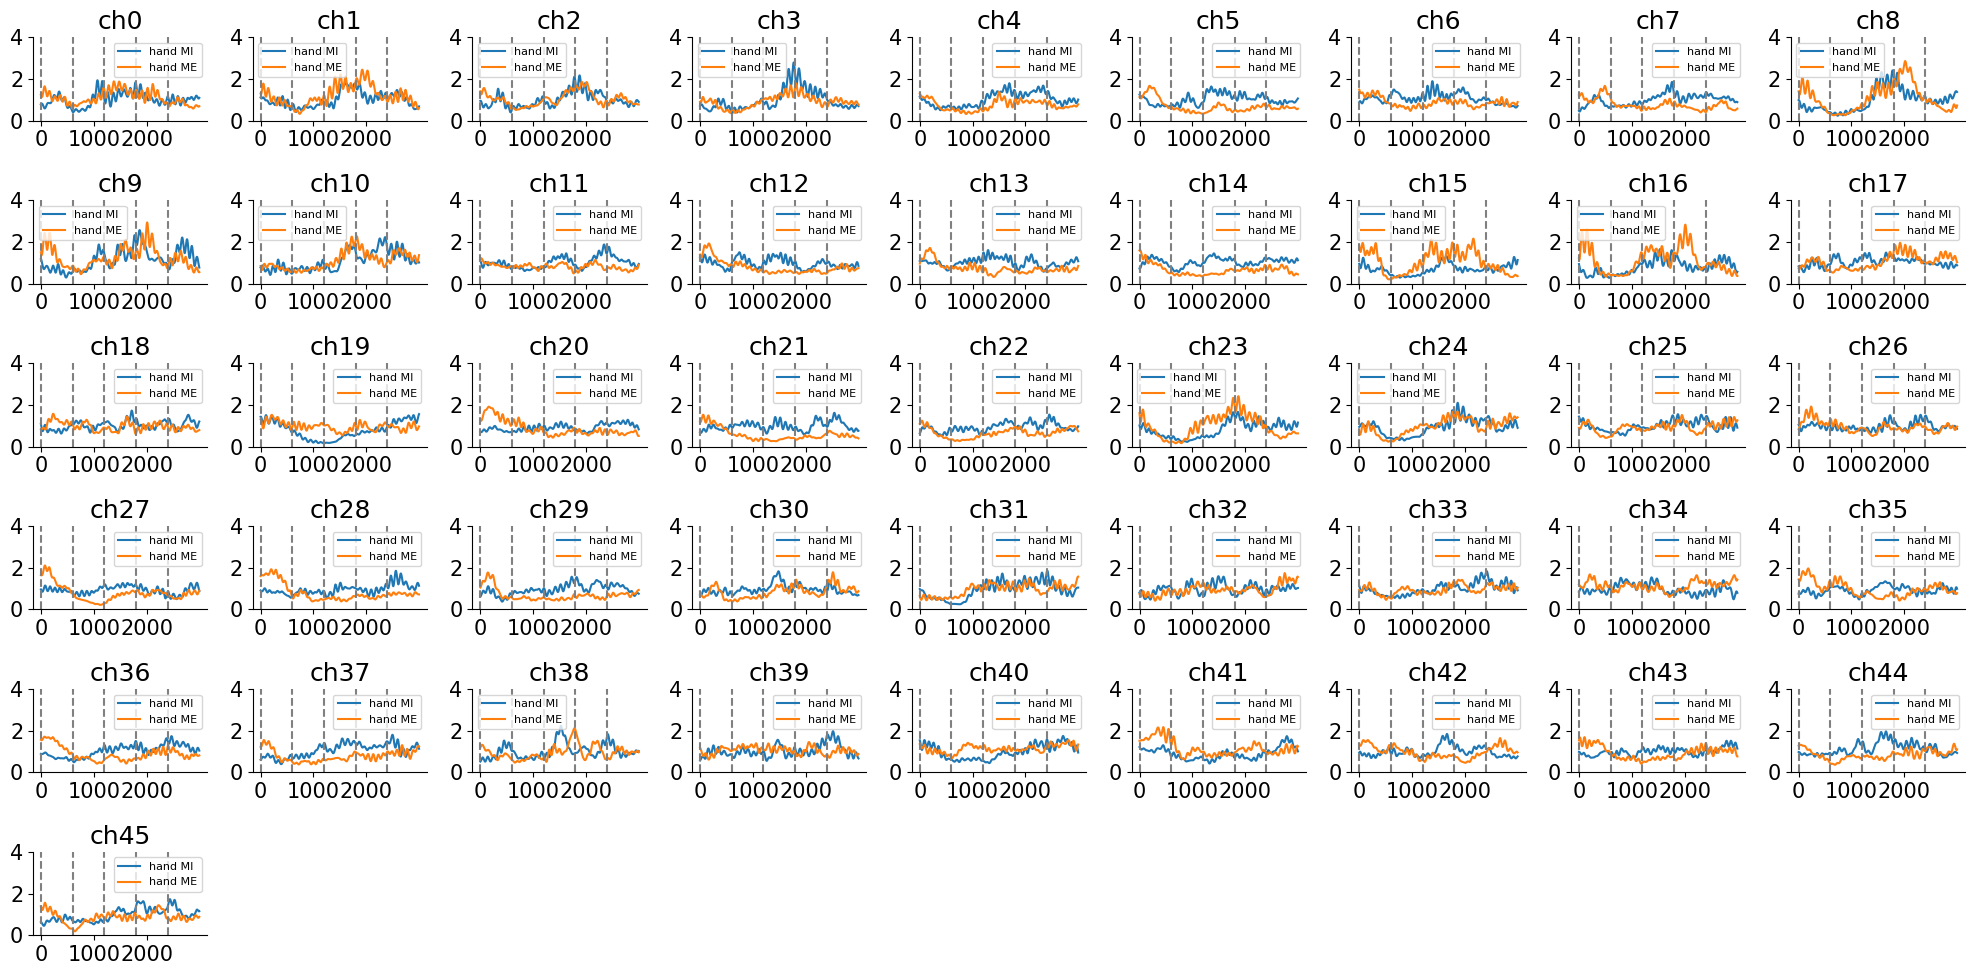

In [20]:
V_theta_hand_mi_mean = V_theta_hand_mi.mean(0)
V_theta_hand_me_mean = V_theta_hand_me.mean(0)
n_chunks = 5

plt.figure(figsize=(20, 10))
for j in range(46):
  ax = plt.subplot(6, 9, j+1)
  plt.plot(trange, V_theta_hand_mi_mean[:, j], label='hand MI')
  plt.plot(trange, V_theta_hand_me_mean[:, j], label='hand ME')
  for line in range(n_chunks):
    plt.axvline(line * 600, linestyle='dashed', color='grey')
  plt.title('ch%d'%j)
  plt.xticks([0, 1000, 2000])
  plt.ylim([0, 4])
  plt.legend(fontsize=8)
plt.show()

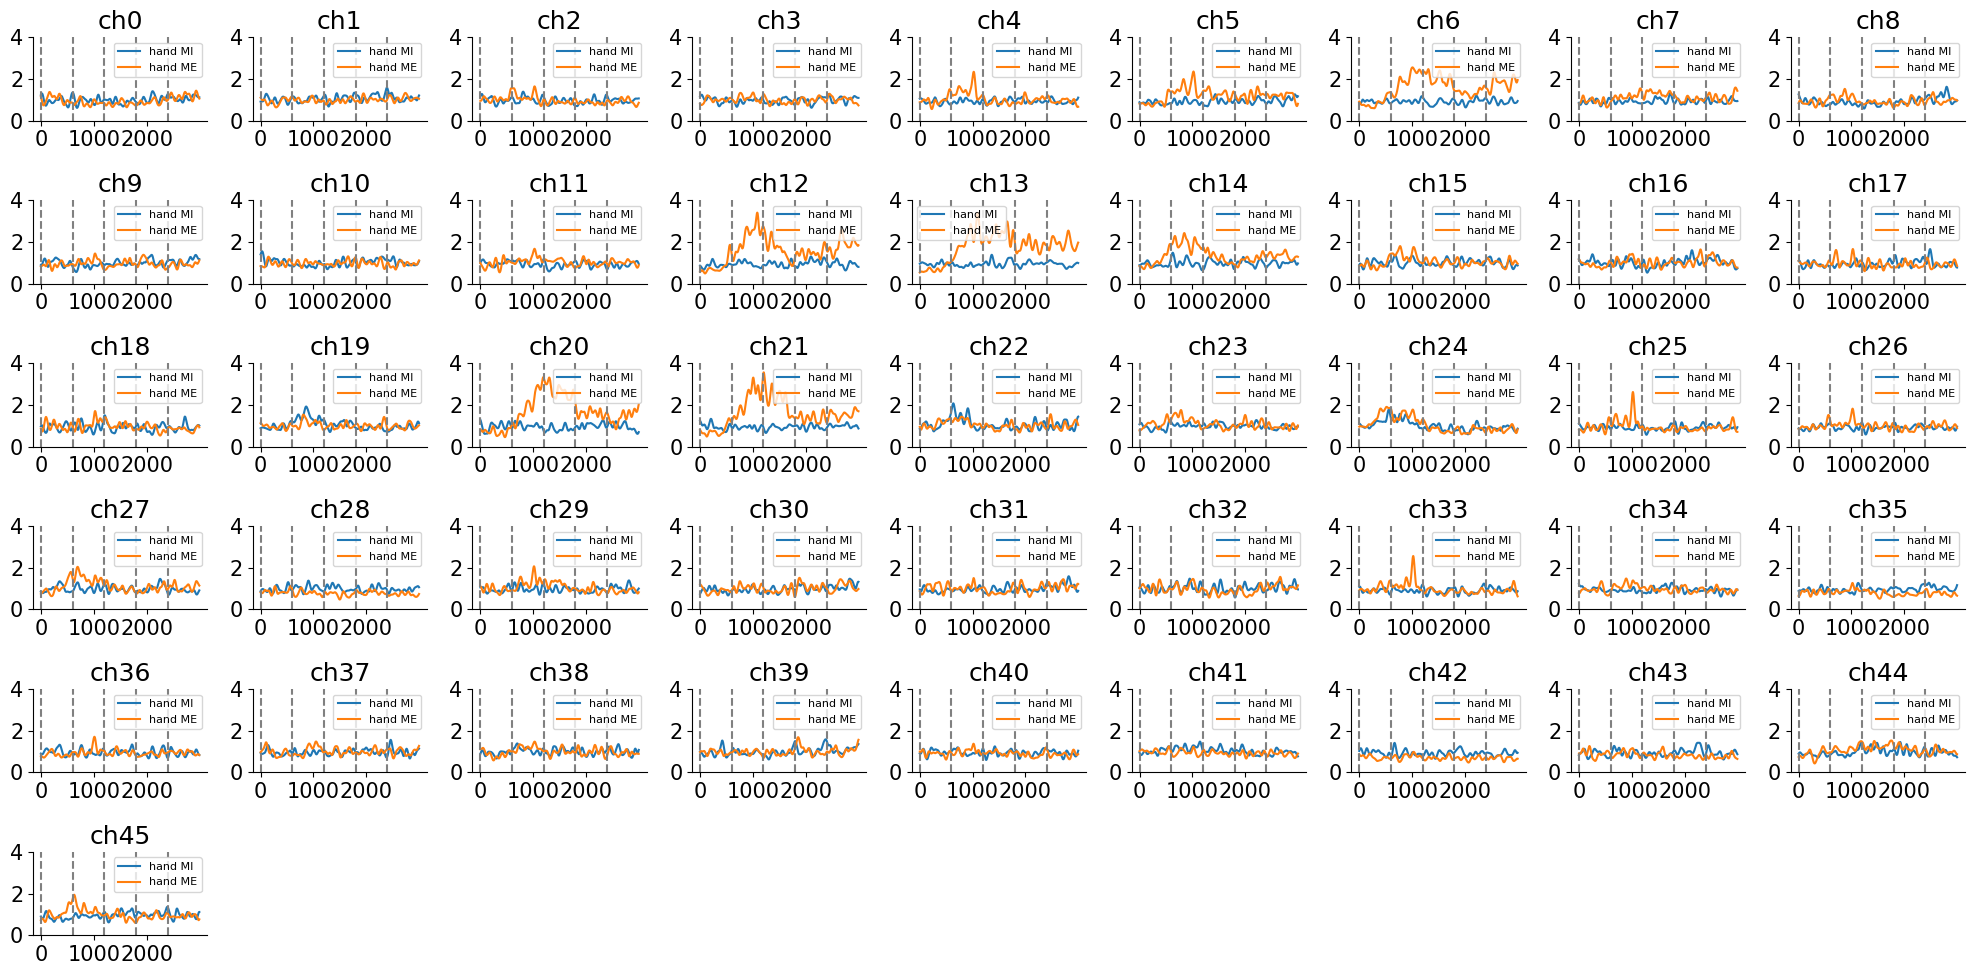

In [21]:
# let's find the electrodes that distinguish tongue from hand movements
# note the behaviors happen some time after the visual cue
V_high_hand_mi_mean = V_high_hand_mi.mean(0)
V_high_hand_me_mean = V_high_hand_me.mean(0)

plt.figure(figsize=(20, 10))
for j in range(46):
  ax = plt.subplot(6, 9, j+1)
  plt.plot(trange, V_high_hand_mi_mean[:, j], label='hand MI')
  plt.plot(trange, V_high_hand_me_mean[:, j], label='hand ME')
  for line in range(n_chunks):
    plt.axvline(line * 600, linestyle='dashed', color='grey')
  plt.title('ch%d'%j)
  plt.xticks([0, 1000, 2000])
  plt.ylim([0, 4])
  plt.legend(fontsize=8)
plt.show()

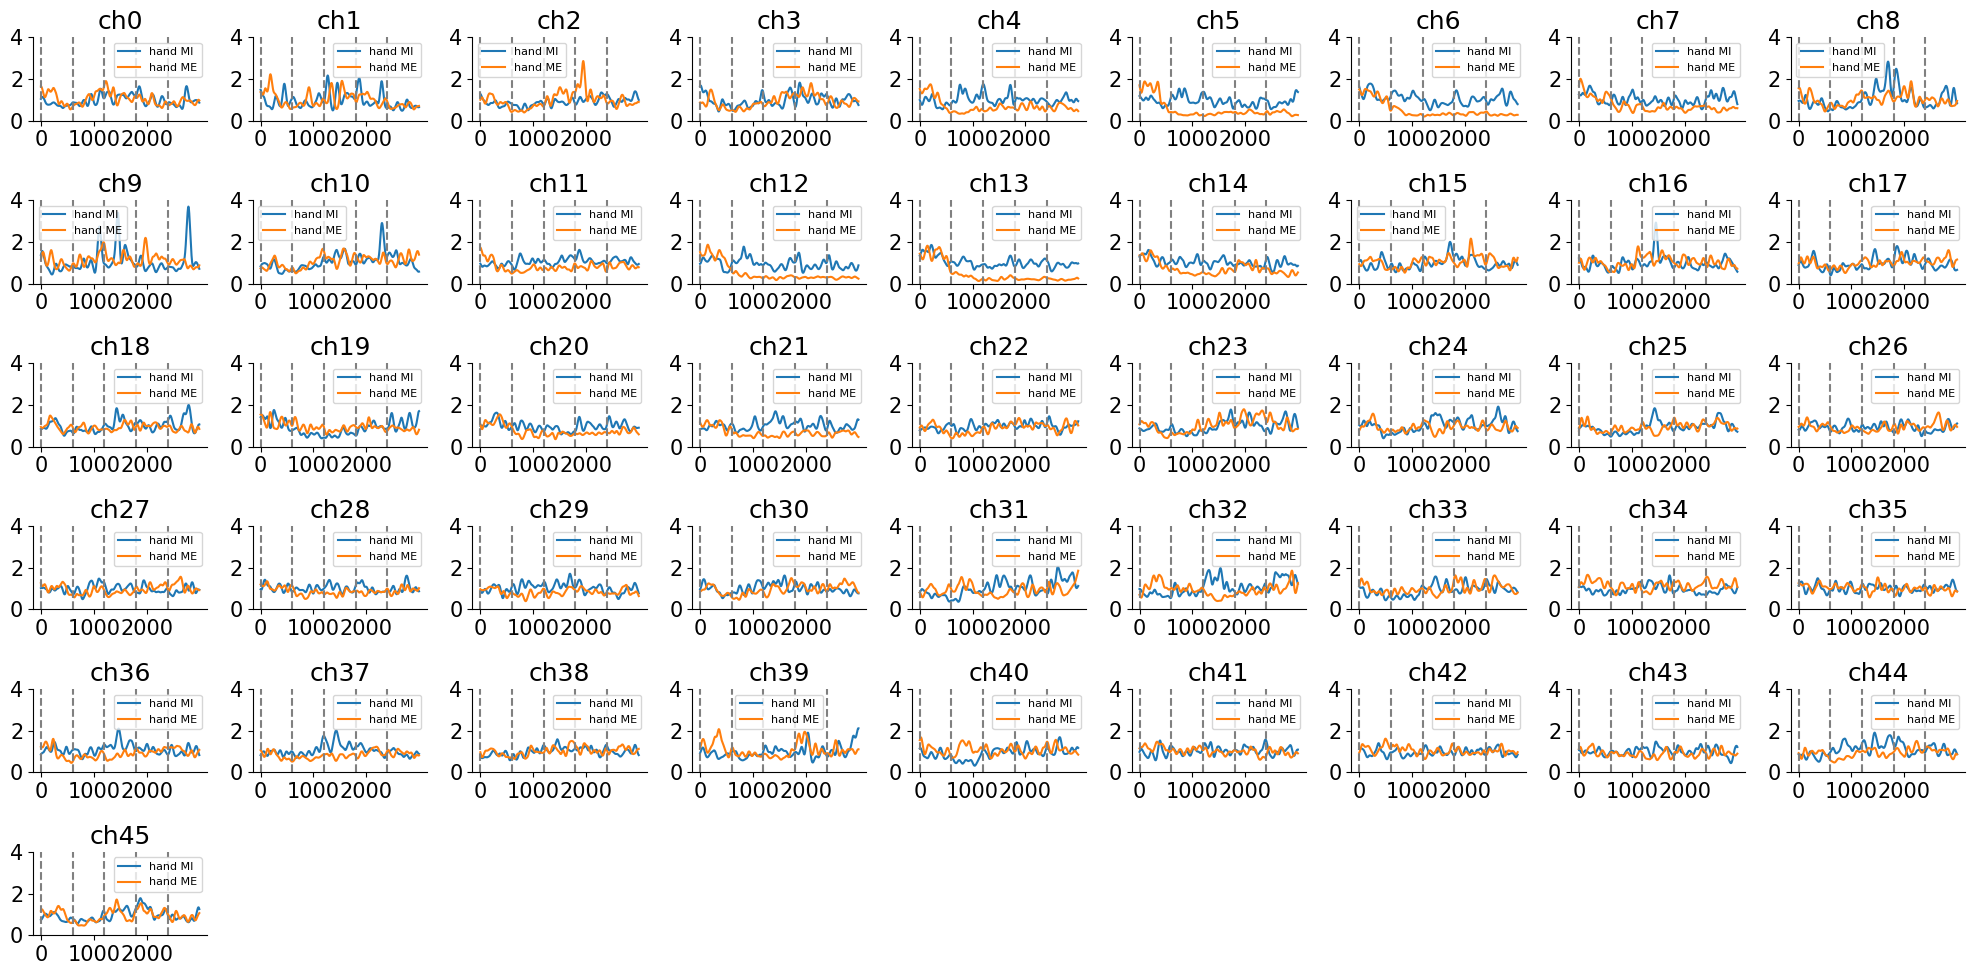

In [22]:
# let's find the electrodes that distinguish tongue from hand movements
# note the behaviors happen some time after the visual cue
V_low_hand_mi_mean = V_low_hand_mi.mean(0)
V_low_hand_me_mean = V_low_hand_me.mean(0)

plt.figure(figsize=(20, 10))
for j in range(46):
  ax = plt.subplot(6, 9, j+1)
  plt.plot(trange, V_low_hand_mi_mean[:, j], label='hand MI')
  plt.plot(trange, V_low_hand_me_mean[:, j], label='hand ME')
  for line in range(n_chunks):
    plt.axvline(line * 600, linestyle='dashed', color='grey')
  plt.title('ch%d'%j)
  plt.xticks([0, 1000, 2000])
  plt.ylim([0, 4])
  plt.legend(fontsize=8)
plt.show()

In [23]:
def extract_time_features(dat, freqs, btype):

    # Design the filter
    b, a = signal.butter(3, freqs, btype=btype, fs=1000)

    # Time series for ME filtered in theta
    V = dat['V']
    V = signal.filtfilt(b, a, V, 0)
    dat_ = dat
    dat_['V'] = V
    V_tongue, V_hand, V_rest = split_dataset(dat_)

    return V_tongue, V_hand, V_rest

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split, LeaveOneOut

trial_len_samp = 3000

# Improve the readability of the code
idxs_all = np.array([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 20, 21, 24, 28, 29, 31, 32, 36, 37, 43])
idxs_m = np.array([3, 4, 5, 6, 7,10, 11, 12, 13, 14,19, 20, 21,28, 29, 36, 37, 43])
idxs_d = np.array([0,8,9,17,18,24,25,26,31,32])
idxs_46 = np.array([24,31,32])
idxs_9 = np.array([17,18,25,26])

n_chunks = 5
window_len = int(trial_len_samp / n_chunks)

In [30]:
def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )
  plt.show()

In [26]:
# Model selection
def model_selection(X, y, C_values, cv = 15, folds=50):

  accuracies_tuning = []
  accuracies_test = []
  weights = []
  for C in C_values:
    # Initialize and fit the model
    accuracies_test_fold = []
    accuracies_tuning_fold = []
    weights_fold = []

    for f in range(folds):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

      # Model definition
      model = LogisticRegression(penalty="l2", C=C, max_iter=2000)

      # Get the accuracy for each test split using cross-validation
      accs = cross_val_score(model, X_train, y_train, cv=cv)

      # Store the average test accuracy for this value of C
      accuracies_tuning_fold.append(np.mean(accs))
      
      # Test on unseen data
      model.fit(X_train, y_train)
      accuracies_test_fold.append(model.score(X_test, y_test))
      weights_fold.append(model.coef_)

    accuracies_tuning.append(np.mean(accuracies_tuning_fold))
    accuracies_test.append(np.mean(accuracies_test_fold))
    weights.append(np.mean(np.array(weights_fold).squeeze(), axis=0))

  return accuracies_tuning, accuracies_test, weights

In [27]:
def plot_features_weights(V_me, V_mi, weights, idxs):
    norm = np.max(np.array([V_me[:,:].mean(0), V_mi[:,:].mean(0)]))
    plt.plot(V_me[:,:].mean(0)/norm, label='ME')
    plt.plot(V_mi[:,:].mean(0)/norm, label='MI')
    #plt.plot(weights, label='weights')
    for line in range(int(V_me.shape[1]/n_chunks)):
        plt.axvline(line * n_chunks, linestyle='dashed', color='grey')
        plt.annotate(f'Ch{idxs[line]}', (line * n_chunks, 0), (line * n_chunks + (n_chunks/3), -.6),
                          fontsize=12, color='red')
    plt.legend()
    plt.show()

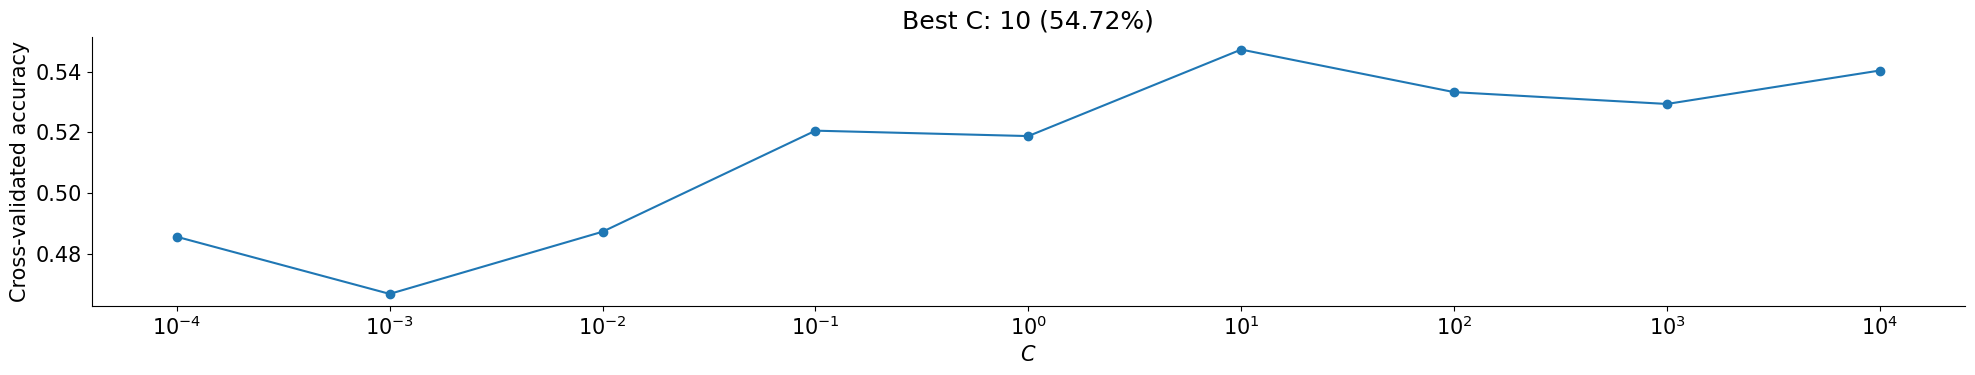

[0.48566666666666664, 0.4668888888888889, 0.48733333333333334, 0.5205555555555555, 0.5187777777777779, 0.5472222222222222, 0.5332222222222223, 0.5293333333333333, 0.5403333333333333]
[0.38166666666666665, 0.39333333333333337, 0.42166666666666663, 0.47833333333333333, 0.53, 0.525, 0.5433333333333333, 0.545, 0.535]
Test accuracy: 52.50%


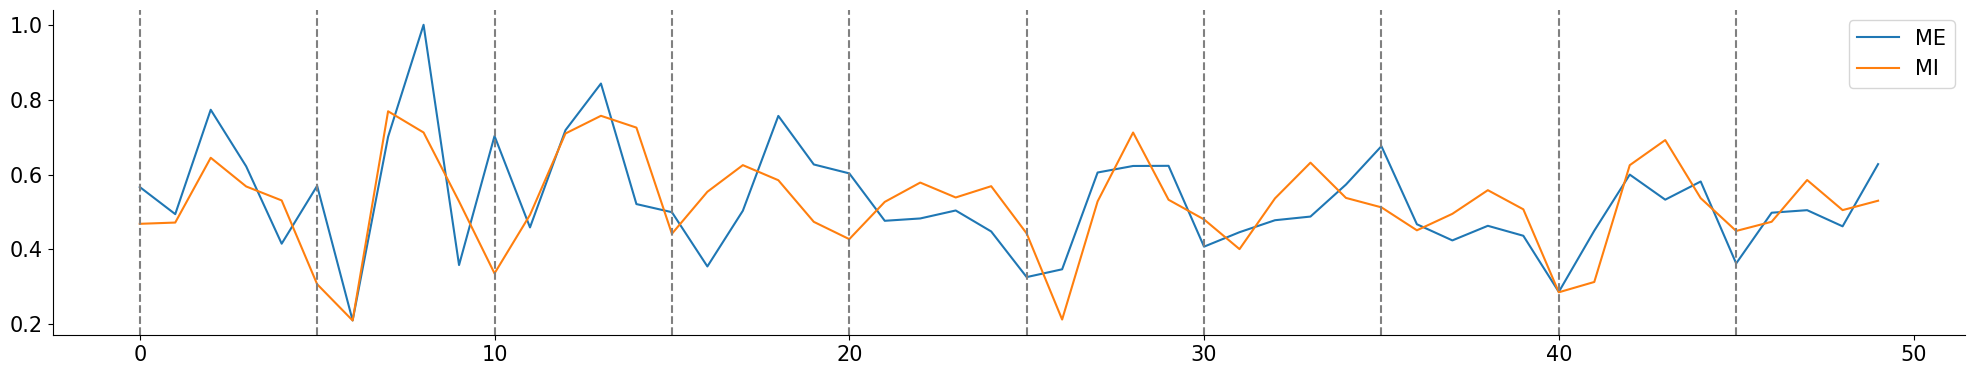

In [31]:
# Theta hand DLPFC
V_theta_hand_me_avg = np.zeros((30, n_chunks, len(idxs_d)))
V_theta_hand_mi_avg = np.zeros((30, n_chunks, len(idxs_d)))

for window in range(int(V_theta_hand_me.shape[1] / window_len)):
    V_theta_hand_me_avg[:, window, :] = np.average(V_theta_hand_me[:,(window*window_len):((window + 1)*(window_len)), idxs_d], axis=1)
    V_theta_hand_mi_avg[:, window, :] = np.average(V_theta_hand_mi[:,(window*window_len):((window + 1)*(window_len)), idxs_d], axis=1)

# transpose
V_theta_hand_me_avg = V_theta_hand_me_avg.transpose(0,2,1)
V_theta_hand_mi_avg = V_theta_hand_mi_avg.transpose(0,2,1)

# reshape
V_theta_hand_me_avg_concat = np.reshape(V_theta_hand_me_avg, (30, -1))
V_theta_hand_mi_avg_concat = np.reshape(V_theta_hand_mi_avg, (30, -1))

# Theta
X = np.concatenate([V_theta_hand_me_avg_concat, V_theta_hand_mi_avg_concat], axis=0)
y = np.concatenate([np.zeros(30), np.ones(30)])

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies_tuning, accuracies_test, weights = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies_tuning)
print(accuracies_tuning)
best_C = np.argmax(accuracies_tuning)
print(accuracies_test)
print(f"Test accuracy: {accuracies_test[best_C]:.2%}")

acc_theta_dlpfc_hand = accuracies_test[best_C]
weights_theta_hand = weights[best_C]
plot_features_weights(V_theta_hand_me_avg_concat, V_theta_hand_mi_avg_concat, weights=weights_theta_hand, idxs=idxs_d)

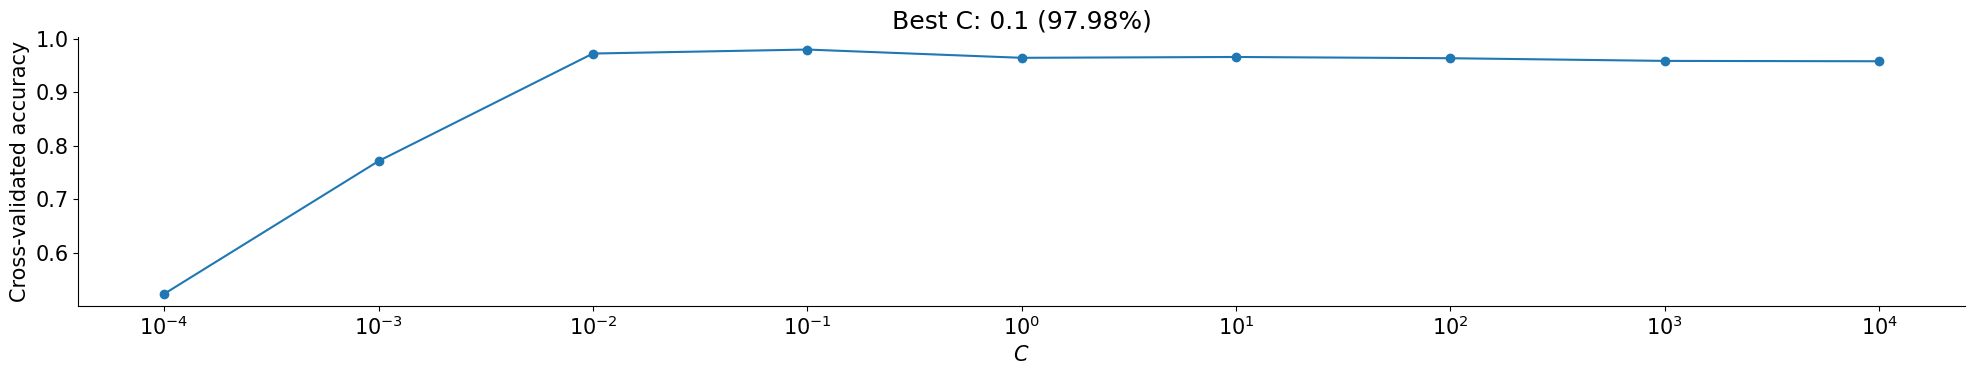

[0.5228888888888887, 0.7712222222222224, 0.9723333333333332, 0.9797777777777779, 0.9643333333333333, 0.9658888888888889, 0.9635555555555557, 0.9585555555555554, 0.9578888888888889]
[0.4700000000000001, 0.7383333333333333, 0.9616666666666666, 0.9883333333333333, 0.98, 0.9649999999999999, 0.9583333333333333, 0.9583333333333331, 0.9533333333333333]
Test accuracy: 98.83%


In [32]:
# High hand
V_high_hand_me_avg = np.zeros((30, n_chunks, len(idxs_m)))
V_high_hand_mi_avg = np.zeros((30, n_chunks, len(idxs_m)))
for window in range(int(V_high_hand_me.shape[1] / window_len)):
    V_high_hand_me_avg[:, window, :] = np.average(V_high_hand_me[:,(window*window_len):((window + 1)*(window_len)), idxs_m], axis=1)
    V_high_hand_mi_avg[:, window, :] = np.average(V_high_hand_mi[:,(window*window_len):((window + 1)*(window_len)), idxs_m], axis=1)

V_high_hand_me_avg = V_high_hand_me_avg.transpose(0,2,1)
V_high_hand_mi_avg = V_high_hand_mi_avg.transpose(0,2,1)

V_high_hand_me_avg_concat = np.reshape(V_high_hand_me_avg, (30, -1))
V_high_hand_mi_avg_concat = np.reshape(V_high_hand_mi_avg, (30, -1))

X = np.concatenate([V_high_hand_me_avg_concat, V_high_hand_mi_avg_concat], axis=0)
y = np.concatenate([np.zeros(30), np.ones(30)])

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies_tuning, accuracies_test, weights = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies_tuning)
print(accuracies_tuning)
best_C = np.argmax(accuracies_tuning)
print(accuracies_test)
print(f"Test accuracy: {accuracies_test[best_C]:.2%}")

acc_high_hand = accuracies_test[best_C]
weights_high_hand = weights[best_C]

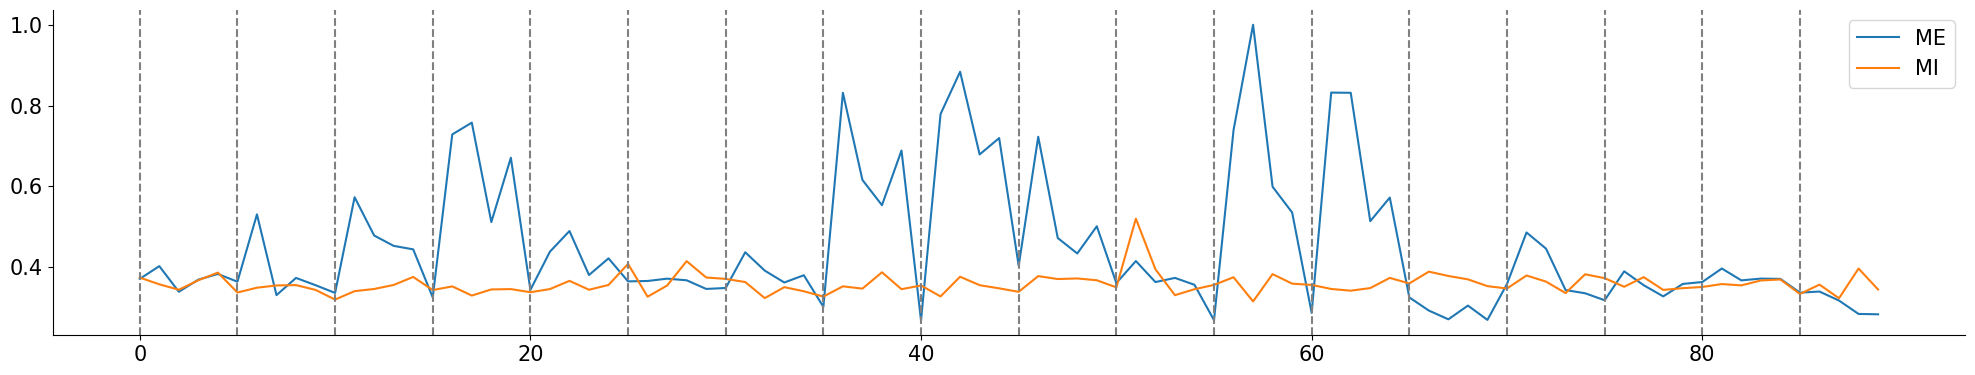

In [33]:
plot_features_weights(V_high_hand_me_avg_concat, V_high_hand_mi_avg_concat, weights=weights_high_hand, idxs=idxs_m)

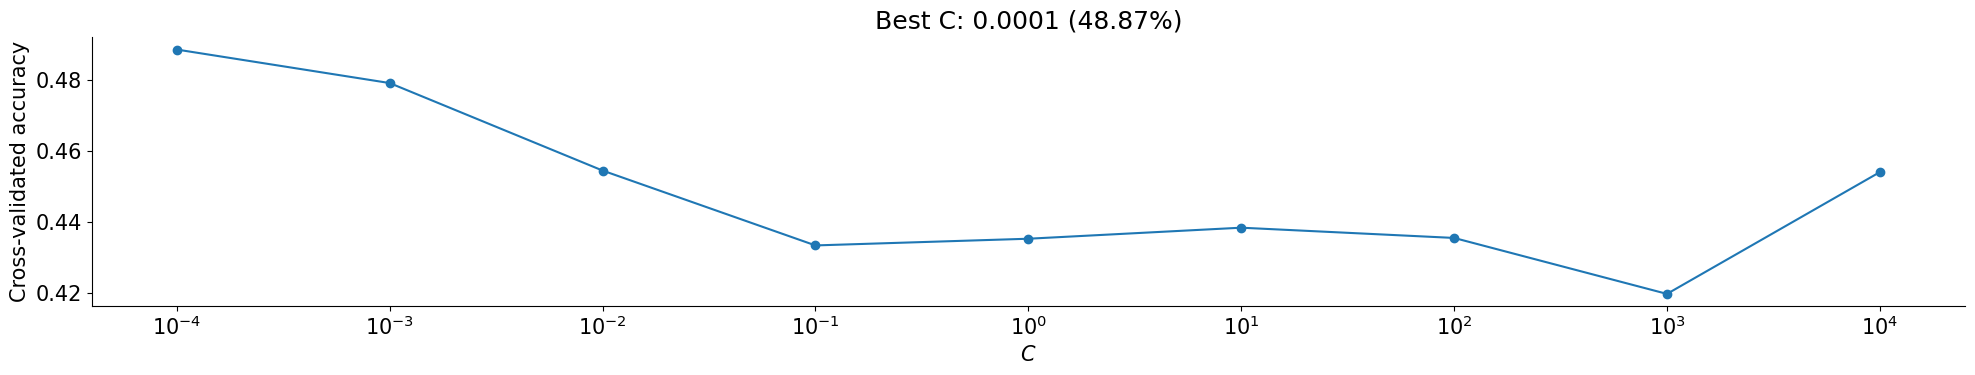

[0.4886666666666667, 0.4792222222222222, 0.45455555555555555, 0.43344444444444435, 0.43533333333333324, 0.4384444444444444, 0.4355555555555555, 0.41977777777777775, 0.45411111111111113]
[0.3766666666666667, 0.37166666666666665, 0.37666666666666665, 0.41833333333333333, 0.445, 0.4216666666666667, 0.41166666666666657, 0.43166666666666664, 0.4083333333333334]
Test accuracy: 37.67%


In [34]:
# Theta hand BA46
V_theta_hand_me_avg = np.zeros((30, n_chunks, len(idxs_46)))
V_theta_hand_mi_avg = np.zeros((30, n_chunks, len(idxs_46)))

for window in range(int(V_theta_hand_me.shape[1] / window_len)):
    V_theta_hand_me_avg[:, window, :] = np.average(V_theta_hand_me[:,(window*window_len):((window + 1)*(window_len)), idxs_46], axis=1)
    V_theta_hand_mi_avg[:, window, :] = np.average(V_theta_hand_mi[:,(window*window_len):((window + 1)*(window_len)), idxs_46], axis=1)

# transpose
V_theta_hand_me_avg = V_theta_hand_me_avg.transpose(0,2,1)
V_theta_hand_mi_avg = V_theta_hand_mi_avg.transpose(0,2,1)

# reshape
V_theta_hand_me_avg_concat = np.reshape(V_theta_hand_me_avg, (30, -1))
V_theta_hand_mi_avg_concat = np.reshape(V_theta_hand_mi_avg, (30, -1))

# Theta
X = np.concatenate([V_theta_hand_me_avg_concat, V_theta_hand_mi_avg_concat], axis=0)
y = np.concatenate([np.zeros(30), np.ones(30)])

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies_tuning, accuracies_test, weights = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies_tuning)
print(accuracies_tuning)
best_C = np.argmax(accuracies_tuning)
print(accuracies_test)
print(f"Test accuracy: {accuracies_test[best_C]:.2%}")

acc_theta_46_hand = accuracies_test[best_C]
weights_46_hand = weights[best_C]

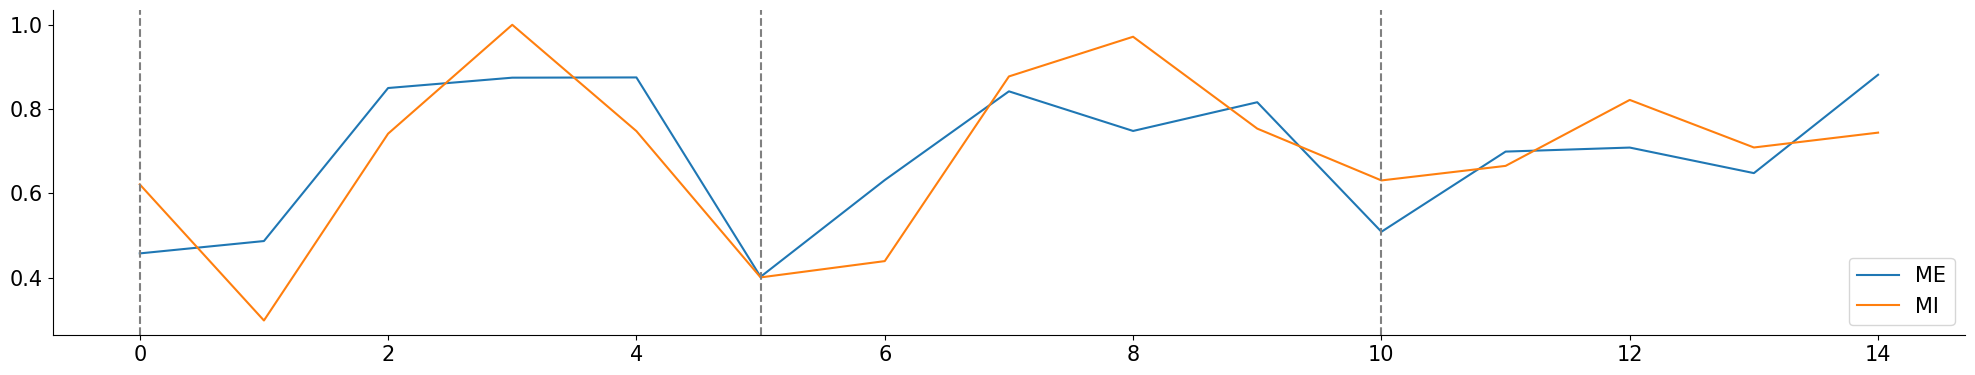

In [35]:
plot_features_weights(V_theta_hand_me_avg_concat, V_theta_hand_mi_avg_concat, weights=weights_46_hand, idxs=idxs_46)

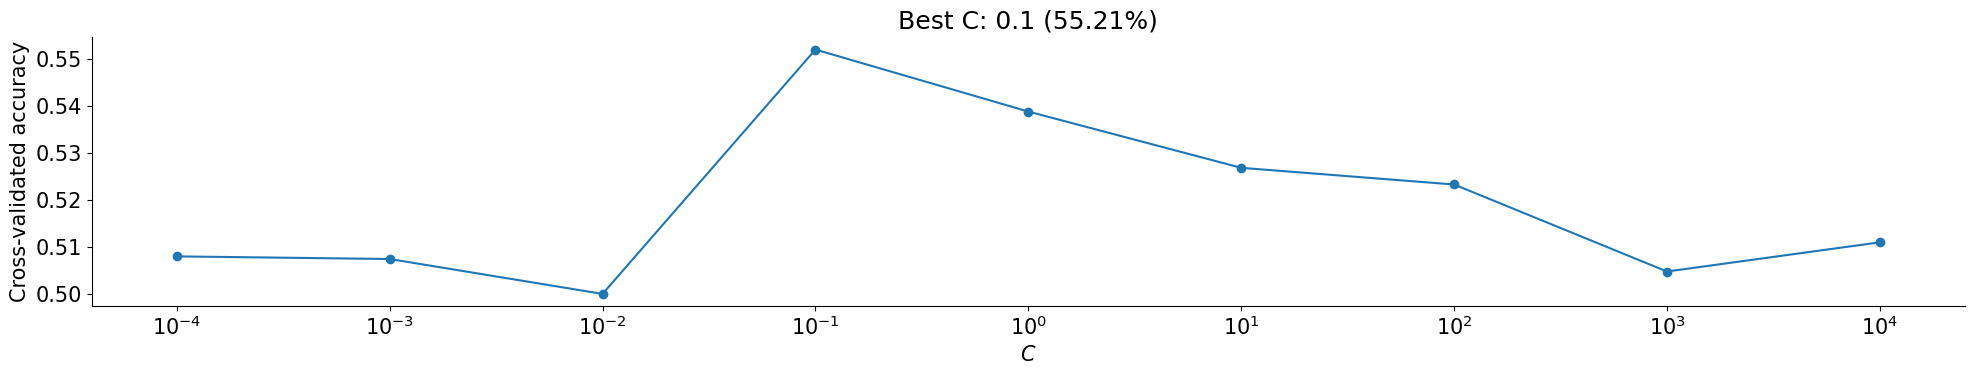

[0.508, 0.5074444444444445, 0.5, 0.5521111111111111, 0.538888888888889, 0.5268888888888889, 0.5233333333333333, 0.5047777777777778, 0.511]
3
Test accuracy: 50.50%


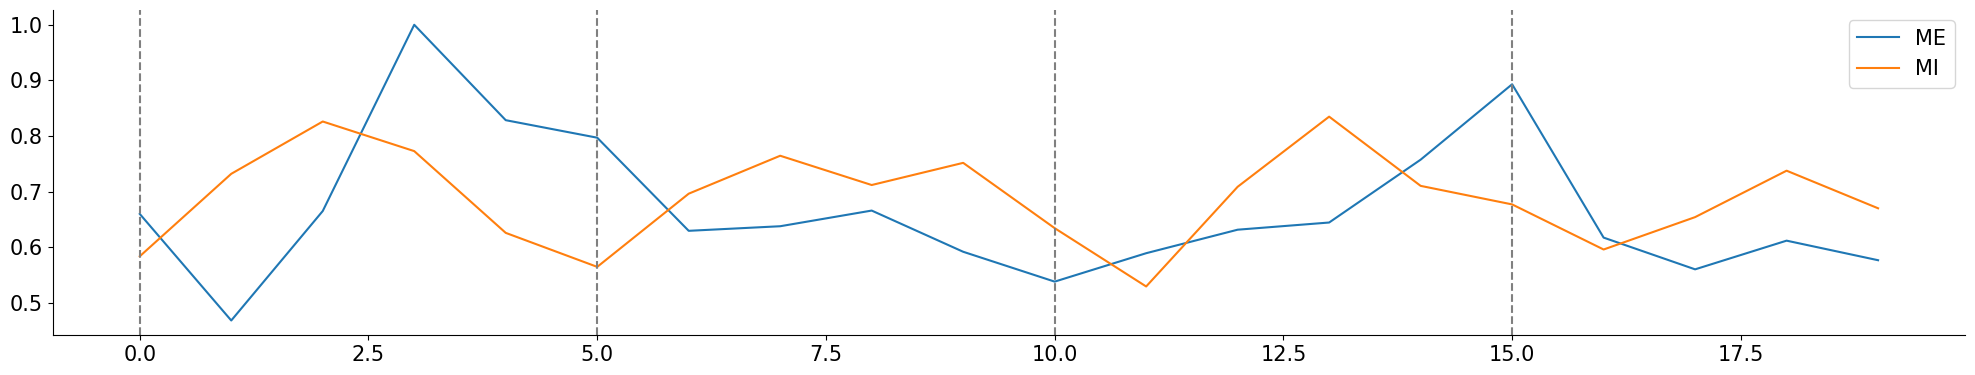

In [36]:
# Theta hand BA9
V_theta_hand_me_avg = np.zeros((30, n_chunks, len(idxs_9)))
V_theta_hand_mi_avg = np.zeros((30, n_chunks, len(idxs_9)))

for window in range(int(V_theta_hand_me.shape[1] / window_len)):
    V_theta_hand_me_avg[:, window, :] = np.average(V_theta_hand_me[:,(window*window_len):((window + 1)*(window_len)), idxs_9], axis=1)
    V_theta_hand_mi_avg[:, window, :] = np.average(V_theta_hand_mi[:,(window*window_len):((window + 1)*(window_len)), idxs_9], axis=1)

# transpose
V_theta_hand_me_avg = V_theta_hand_me_avg.transpose(0,2,1)
V_theta_hand_mi_avg = V_theta_hand_mi_avg.transpose(0,2,1)

# reshape
V_theta_hand_me_avg_concat = np.reshape(V_theta_hand_me_avg, (30, -1))
V_theta_hand_mi_avg_concat = np.reshape(V_theta_hand_mi_avg, (30, -1))

# Theta
X = np.concatenate([V_theta_hand_me_avg_concat, V_theta_hand_mi_avg_concat], axis=0)
y = np.concatenate([np.zeros(30), np.ones(30)])

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies_tuning, accuracies_test, weights = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies_tuning)
print(accuracies_tuning)
best_C = np.argmax(accuracies_tuning)
print(best_C)
print(f"Test accuracy: {accuracies_test[best_C]:.2%}")

acc_theta_9_hand = accuracies_test[best_C]
weights_9_hand = weights[best_C]

plot_features_weights(V_theta_hand_me_avg_concat, V_theta_hand_mi_avg_concat, weights=weights_9_hand, idxs=idxs_9)


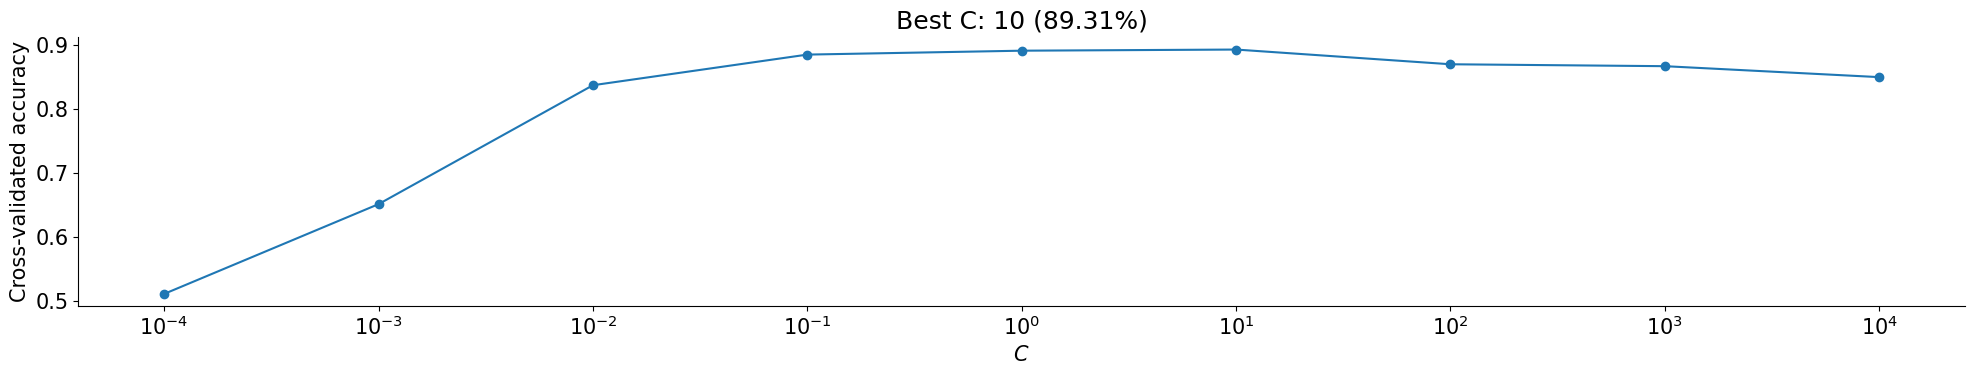

[0.5111111111111111, 0.6514444444444445, 0.8373333333333332, 0.8852222222222222, 0.8913333333333331, 0.8931111111111111, 0.870111111111111, 0.867111111111111, 0.8499999999999999]
5
Test accuracy: 85.33%


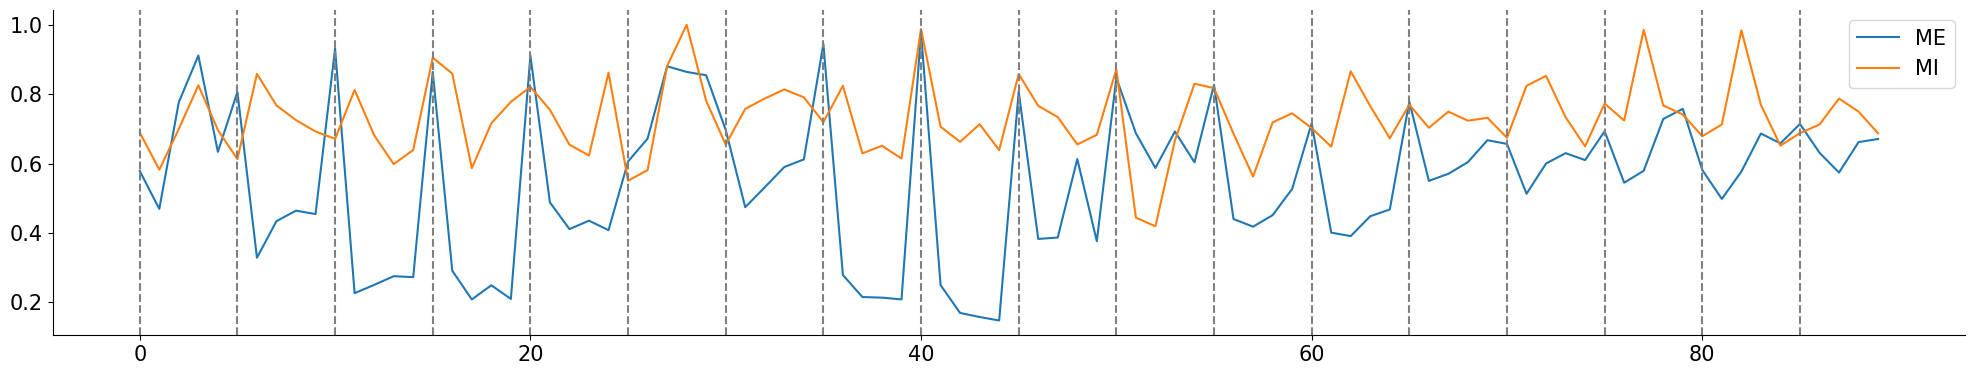

In [38]:

V_low_hand_me_avg = np.zeros((30, n_chunks, len(idxs_m)))
V_low_hand_mi_avg = np.zeros((30, n_chunks, len(idxs_m)))
for window in range(int(V_low_hand_me.shape[1] / window_len)):
    V_low_hand_me_avg[:, window, :] = np.average(V_low_hand_me[:,(window*window_len):((window + 1)*(window_len)), idxs_m], axis=1)
    V_low_hand_mi_avg[:, window, :] = np.average(V_low_hand_mi[:,(window*window_len):((window + 1)*(window_len)), idxs_m], axis=1)

# transpose
V_low_hand_me_avg = V_low_hand_me_avg.transpose(0,2,1)
V_low_hand_mi_avg = V_low_hand_mi_avg.transpose(0,2,1)

V_low_hand_mi_avg_concat = np.reshape(V_low_hand_mi_avg, (30, -1))
V_low_hand_me_avg_concat = np.reshape(V_low_hand_me_avg, (30, -1))

# Low
X = np.concatenate([V_low_hand_me_avg_concat, V_low_hand_mi_avg_concat], axis=0)
y = np.concatenate([np.zeros(30), np.ones(30)])

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies_tuning, accuracies_test, weights = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies_tuning)
print(accuracies_tuning)
best_C = np.argmax(accuracies_tuning)
print(best_C)
print(f"Test accuracy: {accuracies_test[best_C]:.2%}")

acc_low_hand = accuracies_test[best_C]
weights_low_hand = weights[best_C]

plot_features_weights(V_low_hand_me_avg_concat, V_low_hand_mi_avg_concat, weights=weights_low_hand, idxs=idxs_m)


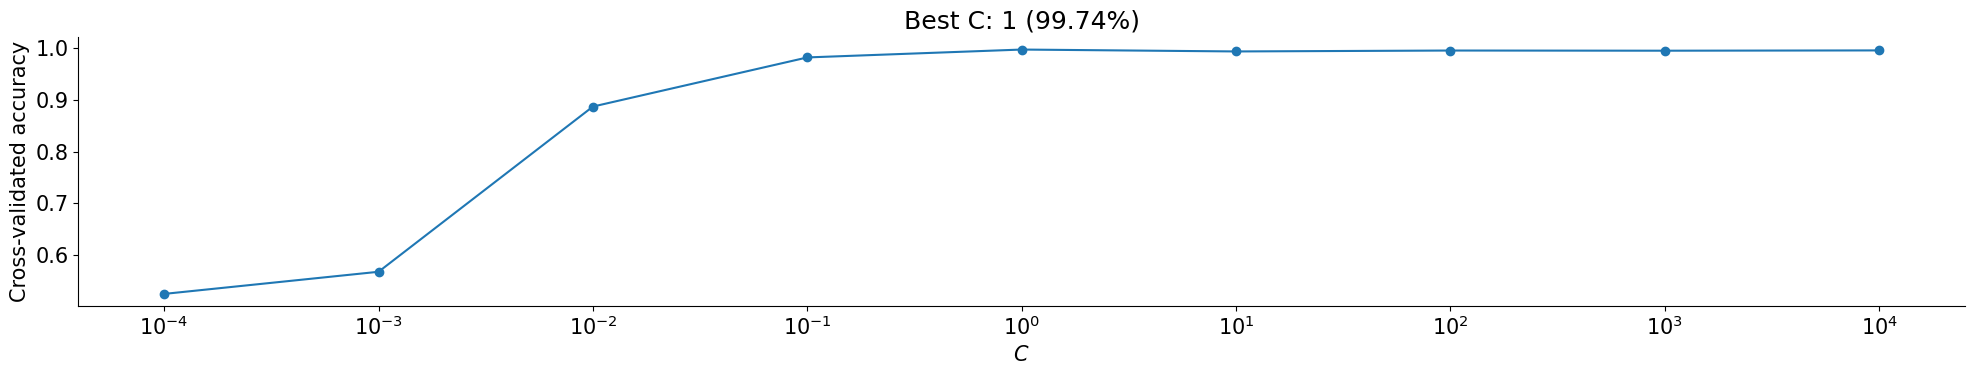

[0.5251111111111111, 0.5678888888888889, 0.8872222222222221, 0.9822222222222221, 0.9974444444444444, 0.9937777777777778, 0.9955555555555557, 0.9952222222222222, 0.9957777777777779]
4
Test accuracy: 99.83%


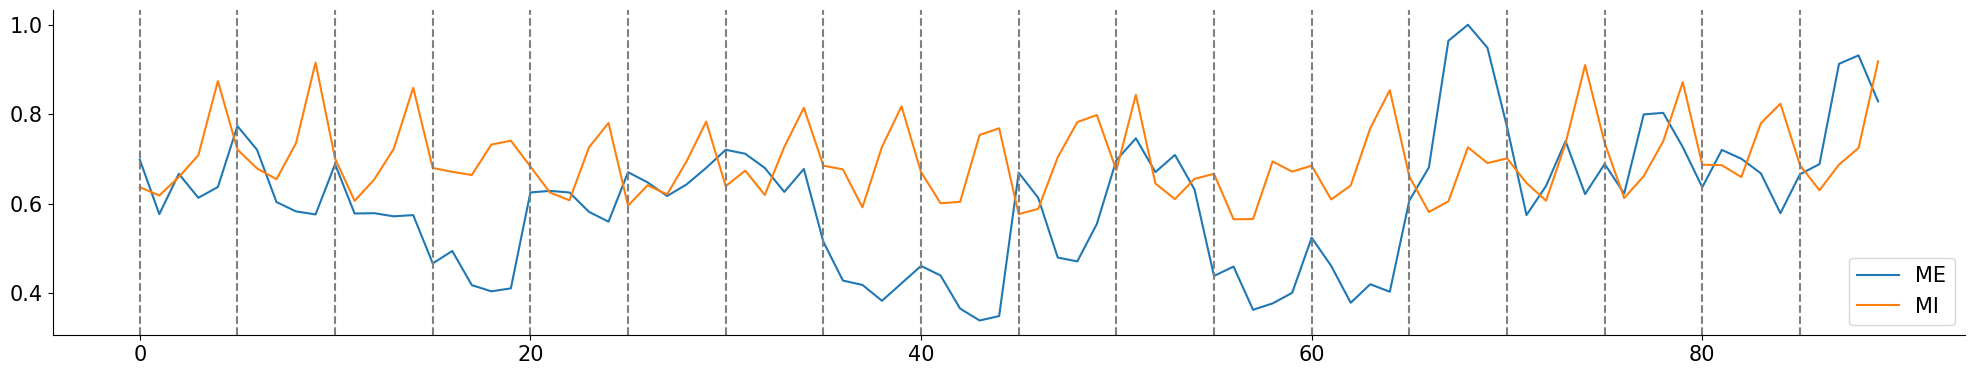

In [41]:
# High tongue
V_high_tongue_me_avg = np.zeros((30, n_chunks, len(idxs_m)))
V_high_tongue_mi_avg = np.zeros((30, n_chunks, len(idxs_m)))
for window in range(int(V_high_tongue_me.shape[1] / window_len)):
    V_high_tongue_me_avg[:, window, :] = np.average(V_high_tongue_me[:,(window*window_len):((window + 1)*(window_len)), idxs_m], axis=1)
    V_high_tongue_mi_avg[:, window, :] = np.average(V_high_tongue_mi[:,(window*window_len):((window + 1)*(window_len)), idxs_m], axis=1)

V_high_tongue_me_avg = V_high_tongue_me_avg.transpose(0,2,1)
V_high_tongue_mi_avg = V_high_tongue_mi_avg.transpose(0,2,1)

V_high_tongue_me_avg_concat = np.reshape(V_high_tongue_me_avg, (30, -1))
V_high_tongue_mi_avg_concat = np.reshape(V_high_tongue_mi_avg, (30, -1))

X = np.concatenate([V_high_tongue_me_avg_concat, V_high_tongue_mi_avg_concat], axis=0)
y = np.concatenate([np.zeros(30), np.ones(30)])

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies_tuning, accuracies_test, weights = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies_tuning)
print(accuracies_tuning)
best_C = np.argmax(accuracies_tuning)
print(best_C)
print(f"Test accuracy: {accuracies_test[best_C]:.2%}")

acc_high_tongue = accuracies_test[best_C]
weights_high_tongue = weights[best_C]

plot_features_weights(V_high_tongue_me_avg_concat, V_high_tongue_mi_avg_concat, weights=weights_high_tongue, idxs=idxs_m)


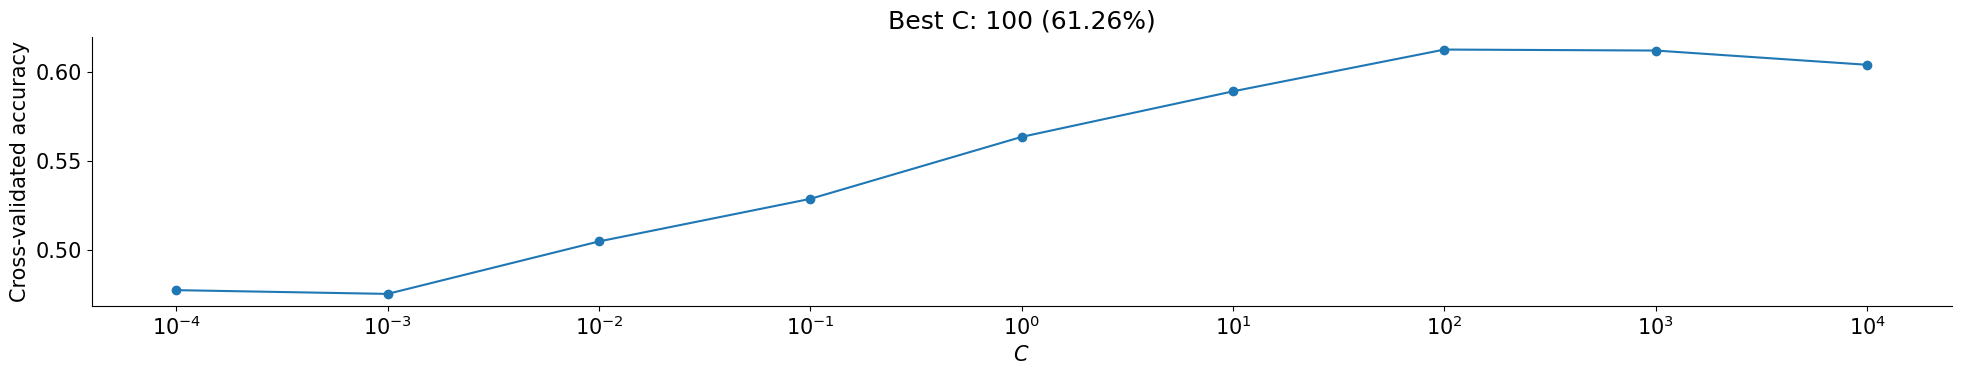

[0.4775555555555555, 0.47544444444444445, 0.5048888888888888, 0.5287777777777778, 0.5635555555555556, 0.5891111111111111, 0.6125555555555556, 0.612, 0.6040000000000001]
6
Test accuracy: 59.67%


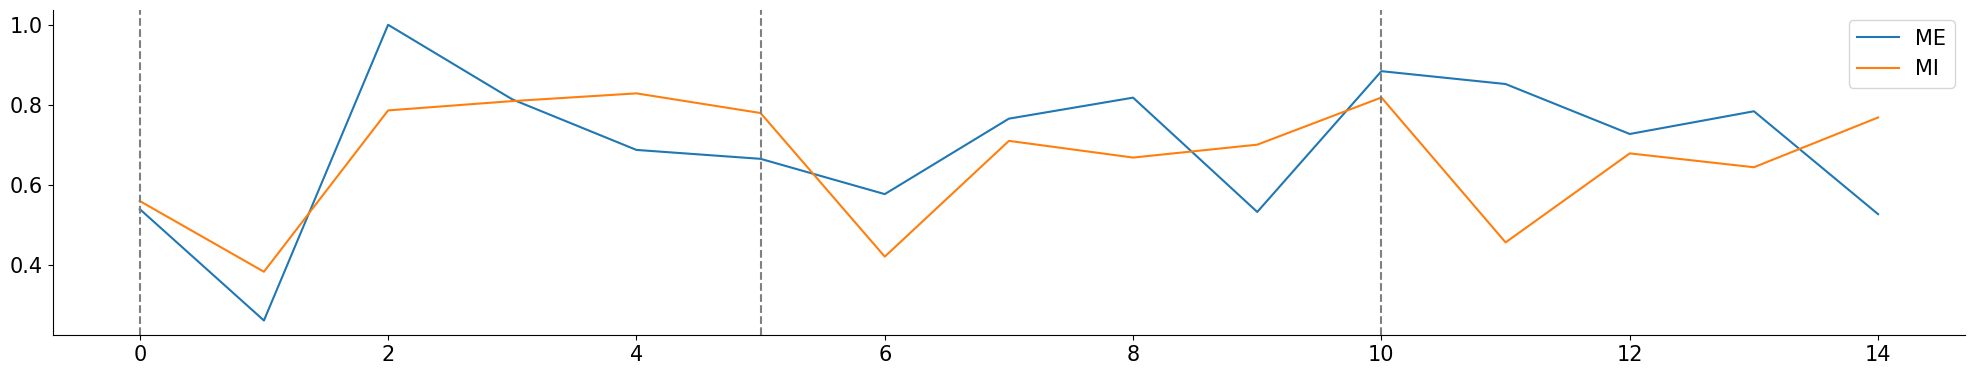

In [42]:
# Theta tongue BA46
V_theta_tongue_me_avg = np.zeros((30, n_chunks, len(idxs_46)))
V_theta_tongue_mi_avg = np.zeros((30, n_chunks, len(idxs_46)))

for window in range(int(V_theta_tongue_me.shape[1] / window_len)):
    V_theta_tongue_me_avg[:, window, :] = np.average(V_theta_tongue_me[:,(window*window_len):((window + 1)*(window_len)), idxs_46], axis=1)
    V_theta_tongue_mi_avg[:, window, :] = np.average(V_theta_tongue_mi[:,(window*window_len):((window + 1)*(window_len)), idxs_46], axis=1)

# transpose
V_theta_tongue_me_avg = V_theta_tongue_me_avg.transpose(0,2,1)
V_theta_tongue_mi_avg = V_theta_tongue_mi_avg.transpose(0,2,1)

# reshape
V_theta_tongue_me_avg_concat = np.reshape(V_theta_tongue_me_avg, (30, -1))
V_theta_tongue_mi_avg_concat = np.reshape(V_theta_tongue_mi_avg, (30, -1))

# Theta
X = np.concatenate([V_theta_tongue_me_avg_concat, V_theta_tongue_mi_avg_concat], axis=0)
y = np.concatenate([np.zeros(30), np.ones(30)])

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies_tuning, accuracies_test, weights = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies_tuning)
print(accuracies_tuning)
best_C = np.argmax(accuracies_tuning)
print(best_C)
print(f"Test accuracy: {accuracies_test[best_C]:.2%}")

acc_theta_46_tongue = accuracies_test[best_C]
weights_46_tongue = weights[best_C]

plot_features_weights(V_theta_tongue_me_avg_concat, V_theta_tongue_mi_avg_concat, weights=weights_46_tongue, idxs=idxs_46)

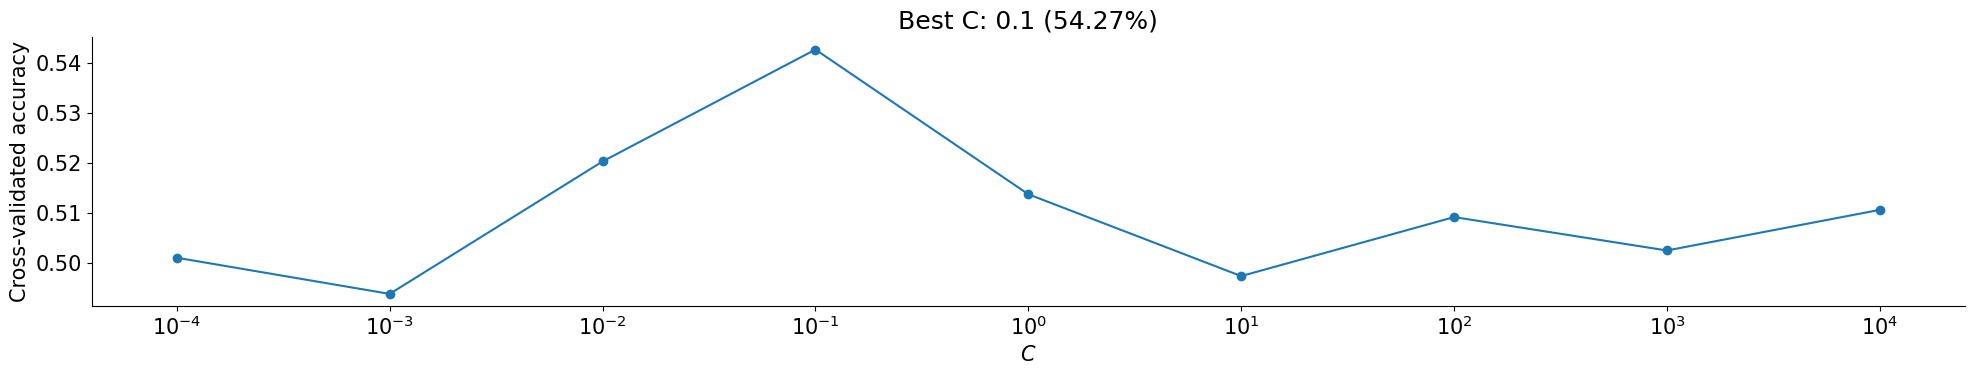

[0.5011111111111112, 0.4938888888888889, 0.5203333333333334, 0.5426666666666667, 0.5137777777777778, 0.4974444444444444, 0.5092222222222222, 0.5025555555555556, 0.5106666666666667]
3
Test accuracy: 48.50%


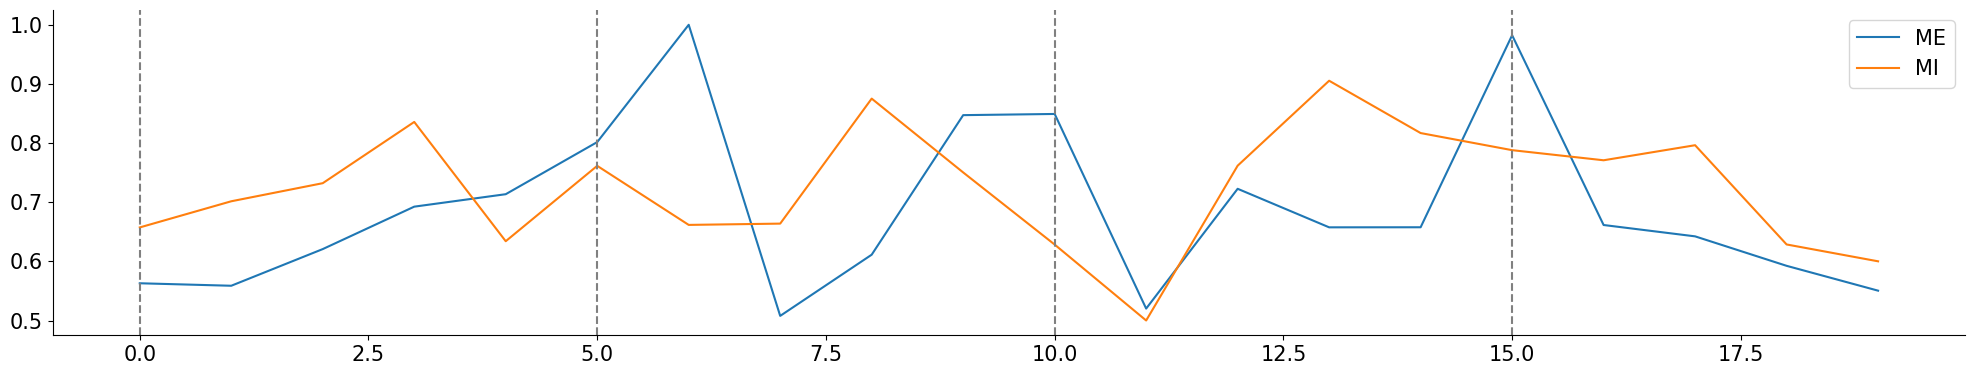

In [43]:
# Theta tongue BA9
V_theta_tongue_me_avg = np.zeros((30, n_chunks, len(idxs_9)))
V_theta_tongue_mi_avg = np.zeros((30, n_chunks, len(idxs_9)))

for window in range(int(V_theta_tongue_me.shape[1] / window_len)):
    V_theta_tongue_me_avg[:, window, :] = np.average(V_theta_tongue_me[:,(window*window_len):((window + 1)*(window_len)), idxs_9], axis=1)
    V_theta_tongue_mi_avg[:, window, :] = np.average(V_theta_tongue_mi[:,(window*window_len):((window + 1)*(window_len)), idxs_9], axis=1)

# transpose
V_theta_tongue_me_avg = V_theta_tongue_me_avg.transpose(0,2,1)
V_theta_tongue_mi_avg = V_theta_tongue_mi_avg.transpose(0,2,1)

# reshape
V_theta_tongue_me_avg_concat = np.reshape(V_theta_tongue_me_avg, (30, -1))
V_theta_tongue_mi_avg_concat = np.reshape(V_theta_tongue_mi_avg, (30, -1))

# Theta
X = np.concatenate([V_theta_tongue_me_avg_concat, V_theta_tongue_mi_avg_concat], axis=0)
y = np.concatenate([np.zeros(30), np.ones(30)])

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies_tuning, accuracies_test, weights = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies_tuning)
print(accuracies_tuning)
best_C = np.argmax(accuracies_tuning)
print(best_C)
print(f"Test accuracy: {accuracies_test[best_C]:.2%}")

acc_theta_9_tongue = accuracies_test[best_C]
weights_9_tongue = weights[best_C]

plot_features_weights(V_theta_tongue_me_avg_concat, V_theta_tongue_mi_avg_concat, weights=weights_9_tongue, idxs=idxs_9)

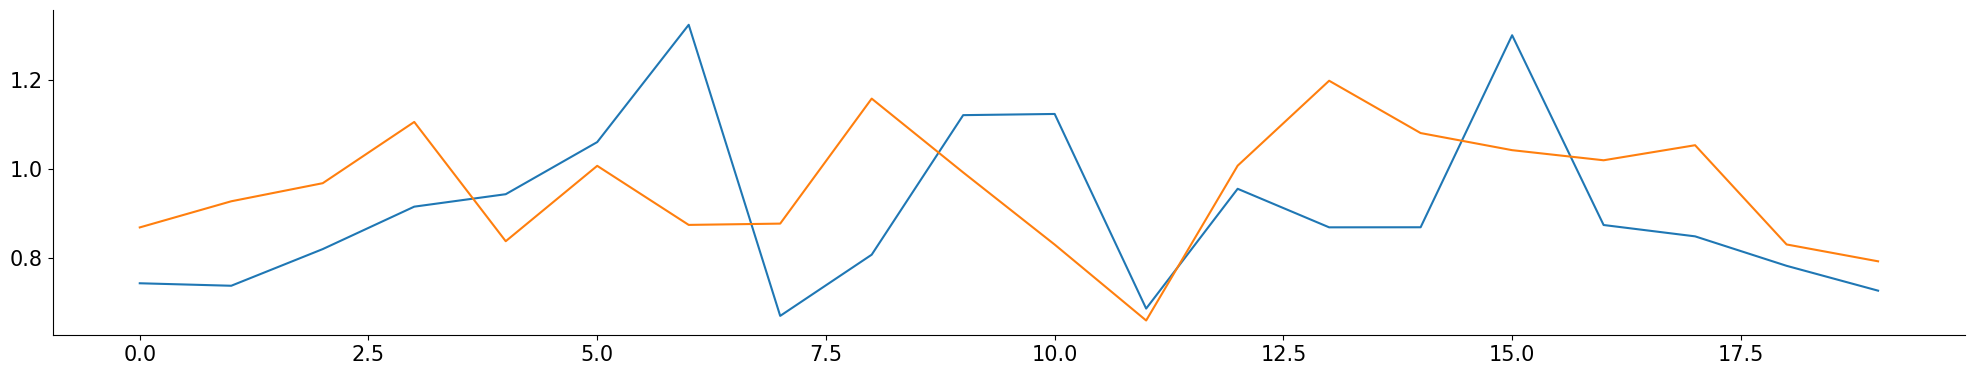

In [85]:
plt.plot(V_theta_tongue_me_avg_concat[:,:].mean(0))
plt.plot(V_theta_tongue_mi_avg_concat[:,:].mean(0))
plt.show()

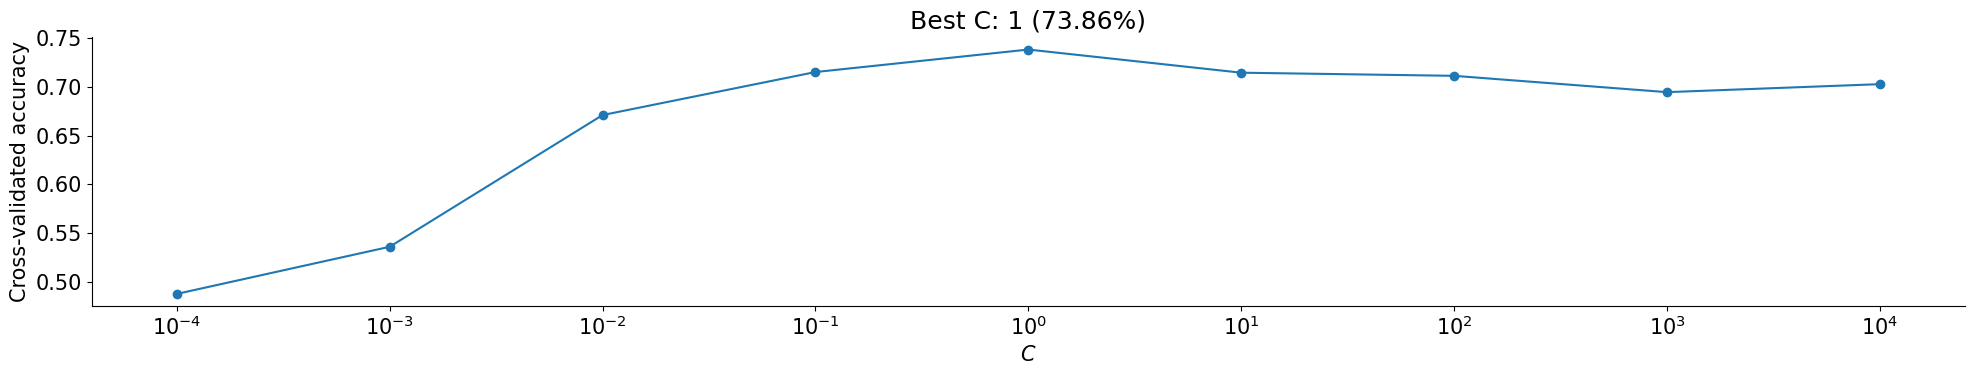

[0.4874444444444444, 0.5358888888888889, 0.6712222222222222, 0.7154444444444443, 0.7385555555555554, 0.7147777777777777, 0.7115555555555556, 0.6947777777777776, 0.7029999999999998]
[0.475, 0.43833333333333335, 0.6399999999999999, 0.69, 0.6783333333333335, 0.6966666666666665, 0.7133333333333334, 0.7166666666666667, 0.7033333333333335]
Test accuracy: 67.83%


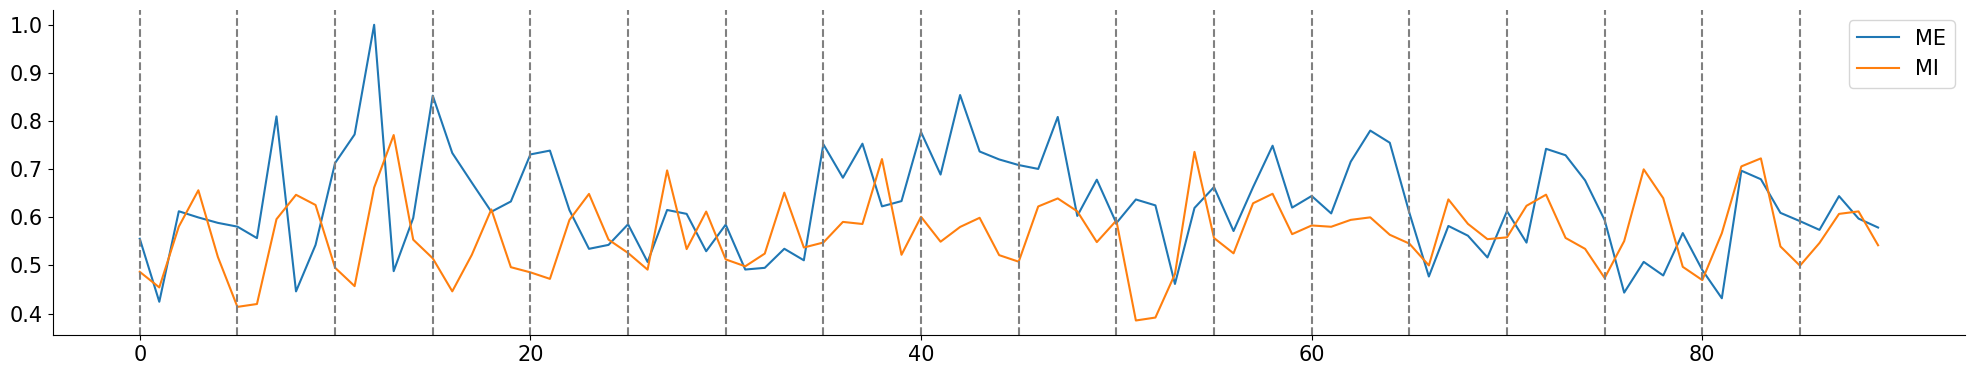

In [44]:
V_low_tongue_me_avg = np.zeros((30, n_chunks, len(idxs_m)))
V_low_tongue_mi_avg = np.zeros((30, n_chunks, len(idxs_m)))
for window in range(int(V_low_tongue_me.shape[1] / window_len)):
    V_low_tongue_me_avg[:, window, :] = np.average(V_low_tongue_me[:,(window*window_len):((window + 1)*(window_len)), idxs_m], axis=1)
    V_low_tongue_mi_avg[:, window, :] = np.average(V_low_tongue_mi[:,(window*window_len):((window + 1)*(window_len)), idxs_m], axis=1)

# transpose
V_low_tongue_me_avg = V_low_tongue_me_avg.transpose(0,2,1)
V_low_tongue_mi_avg = V_low_tongue_mi_avg.transpose(0,2,1)

V_low_tongue_mi_avg_concat = np.reshape(V_low_tongue_mi_avg, (30, -1))
V_low_tongue_me_avg_concat = np.reshape(V_low_tongue_me_avg, (30, -1))

# Low
X = np.concatenate([V_low_tongue_me_avg_concat, V_low_tongue_mi_avg_concat], axis=0)
y = np.concatenate([np.zeros(30), np.ones(30)])

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies_tuning, accuracies_test, weights = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies_tuning)
print(accuracies_tuning)
best_C = np.argmax(accuracies_tuning)
print(accuracies_test)
print(f"Test accuracy: {accuracies_test[best_C]:.2%}")

acc_low_tongue = accuracies_test[best_C]
weights_low_tongue = weights[best_C]

plot_features_weights(V_low_tongue_me_avg_concat, V_low_tongue_mi_avg_concat, weights=weights_low_tongue, idxs=idxs_m)

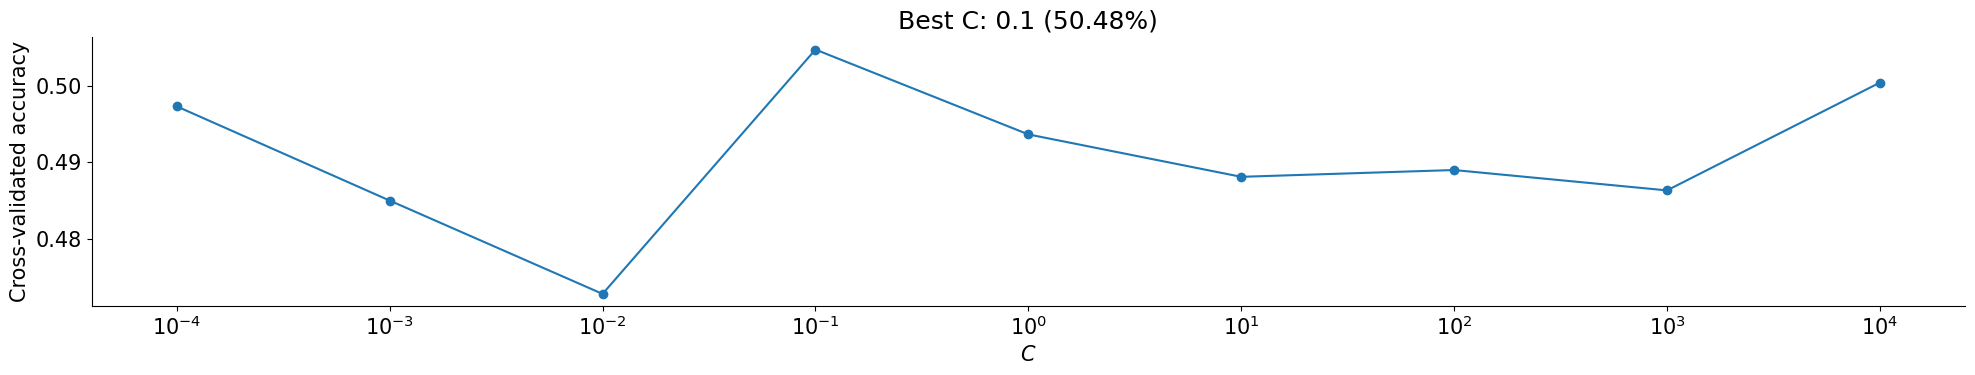

[0.49733333333333335, 0.485, 0.4727777777777778, 0.5047777777777778, 0.4936666666666666, 0.4881111111111111, 0.489, 0.4863333333333334, 0.5004444444444445]
[0.38499999999999995, 0.39666666666666656, 0.45166666666666666, 0.4516666666666667, 0.4966666666666667, 0.4966666666666667, 0.5016666666666666, 0.4766666666666666, 0.45833333333333337]
Test accuracy: 45.17%


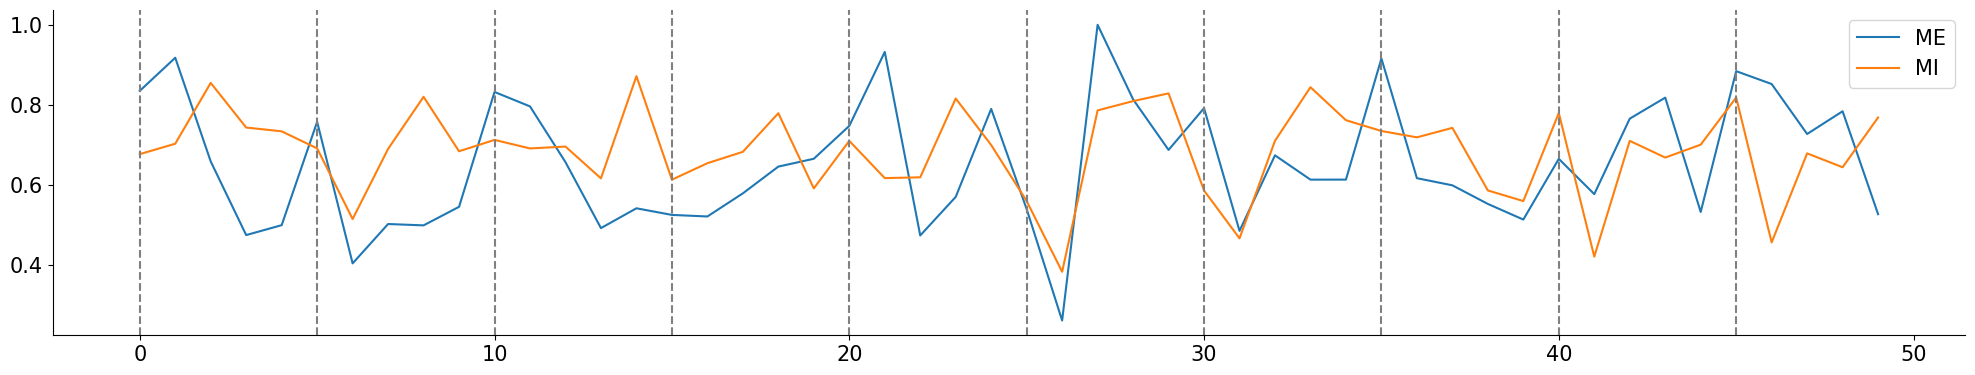

In [45]:
# Theta tongue DLPFC
V_theta_tongue_me_avg = np.zeros((30, n_chunks, len(idxs_d)))
V_theta_tongue_mi_avg = np.zeros((30, n_chunks, len(idxs_d)))

for window in range(int(V_theta_tongue_me.shape[1] / window_len)):
    V_theta_tongue_me_avg[:, window, :] = np.average(V_theta_tongue_me[:,(window*window_len):((window + 1)*(window_len)), idxs_d], axis=1)
    V_theta_tongue_mi_avg[:, window, :] = np.average(V_theta_tongue_mi[:,(window*window_len):((window + 1)*(window_len)), idxs_d], axis=1)

# transpose
V_theta_tongue_me_avg = V_theta_tongue_me_avg.transpose(0,2,1)
V_theta_tongue_mi_avg = V_theta_tongue_mi_avg.transpose(0,2,1)

# reshape
V_theta_tongue_me_avg_concat = np.reshape(V_theta_tongue_me_avg, (30, -1))
V_theta_tongue_mi_avg_concat = np.reshape(V_theta_tongue_mi_avg, (30, -1))

# Theta
X = np.concatenate([V_theta_tongue_me_avg_concat, V_theta_tongue_mi_avg_concat], axis=0)
y = np.concatenate([np.zeros(30), np.ones(30)])

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies_tuning, accuracies_test, weights = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies_tuning)
print(accuracies_tuning)
best_C = np.argmax(accuracies_tuning)
print(accuracies_test)
print(f"Test accuracy: {accuracies_test[best_C]:.2%}")

acc_theta_dlpfc_tongue = accuracies_test[best_C]
weights_theta_tongue = weights[best_C]

plot_features_weights(V_theta_tongue_me_avg_concat, V_theta_tongue_mi_avg_concat, weights=weights_theta_tongue, idxs=idxs_d)

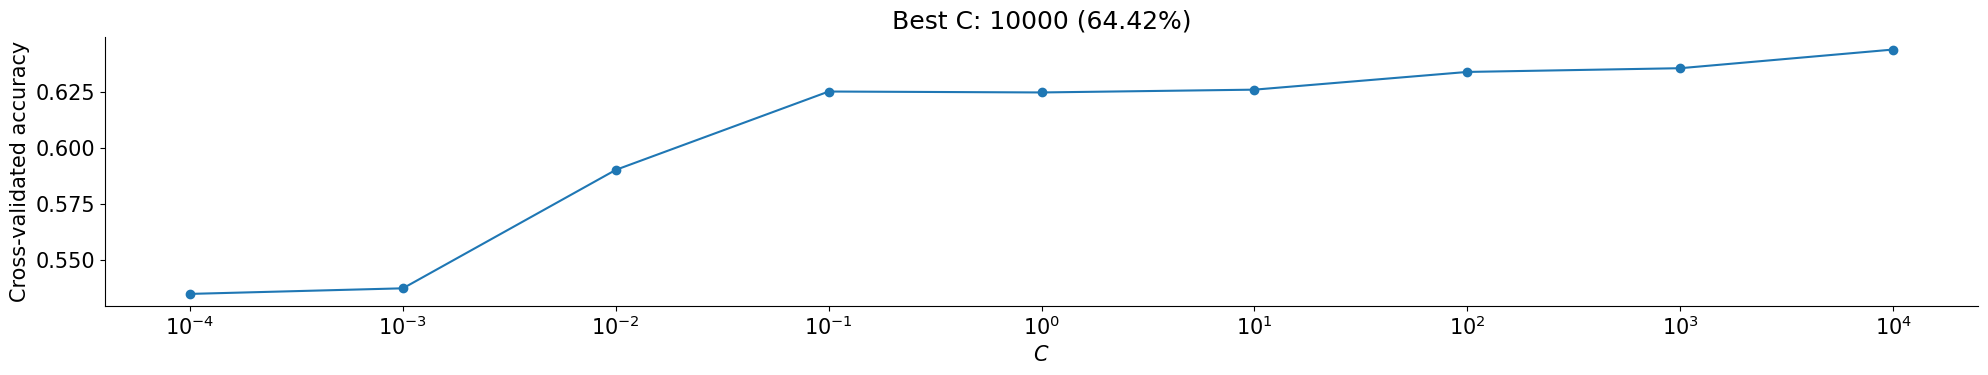

[0.5349999999999999, 0.5375, 0.5904166666666666, 0.6254166666666666, 0.6249999999999999, 0.62625, 0.6341666666666668, 0.6358333333333333, 0.6441666666666666]
8
Test accuracy: 67.67%


In [93]:
# Theta tongue ALL CHS
V_theta_tongue_me_avg = np.zeros((30, n_chunks, 46))
V_theta_tongue_mi_avg = np.zeros((30, n_chunks, 46))

for window in range(int(V_theta_tongue_me.shape[1] / window_len)):
    V_theta_tongue_me_avg[:, window, :] = np.average(V_theta_tongue_me[:,(window*window_len):((window + 1)*(window_len)), :], axis=1)
    V_theta_tongue_mi_avg[:, window, :] = np.average(V_theta_tongue_mi[:,(window*window_len):((window + 1)*(window_len)), :], axis=1)

# transpose
V_theta_tongue_me_avg = V_theta_tongue_me_avg.transpose(0,2,1)
V_theta_tongue_mi_avg = V_theta_tongue_mi_avg.transpose(0,2,1)

# reshape
V_theta_tongue_me_avg_concat = np.reshape(V_theta_tongue_me_avg, (30, -1))
V_theta_tongue_mi_avg_concat = np.reshape(V_theta_tongue_mi_avg, (30, -1))

# Theta
X = np.concatenate([V_theta_tongue_me_avg_concat, V_theta_tongue_mi_avg_concat], axis=0)
y = np.concatenate([np.zeros(30), np.ones(30)])

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies_tuning, accuracies_test = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies_tuning)
print(accuracies_tuning)
best_C = np.argmax(accuracies_tuning)
print(best_C)
print(f"Test accuracy: {accuracies_test[best_C]:.2%}")

acc_theta_allchs_tongue = accuracies_test[best_C]

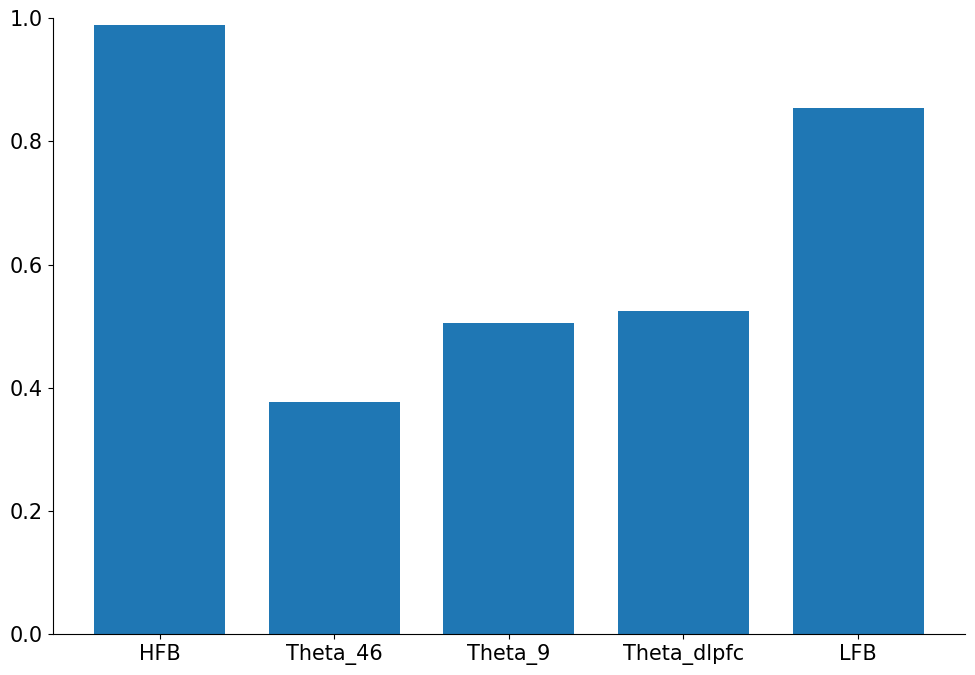

In [46]:
width = .75
plt.figure(figsize=(10,7))
plt.bar(['HFB', 'Theta_46', 'Theta_9', 'Theta_dlpfc','LFB'], [acc_high_hand, acc_theta_46_hand, acc_theta_9_hand, acc_theta_dlpfc_hand, acc_low_hand], width)
plt.ylim(0,1)
plt.savefig('Hand_final.svg')

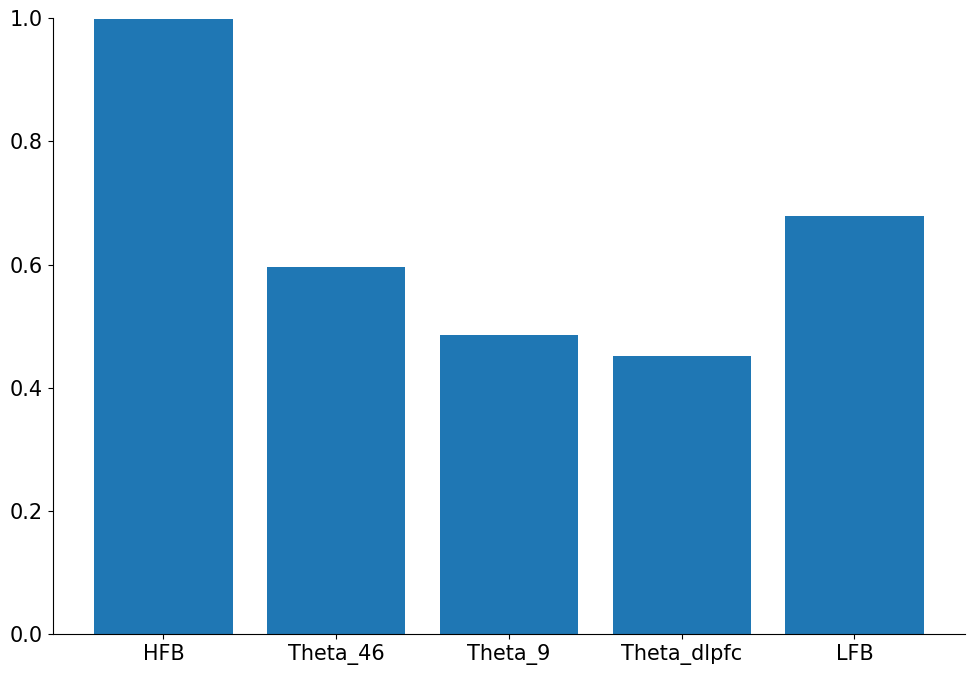

In [49]:
width = .75
plt.figure(figsize=(10,7))
plt.ylim(0,1)
plt.bar(['HFB', 'Theta_46', 'Theta_9', 'Theta_dlpfc', 'LFB'], [acc_high_tongue, acc_theta_46_tongue, acc_theta_9_tongue, acc_theta_dlpfc_tongue, acc_low_tongue])
plt.savefig('Tongue_final.svg')